In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from crepes.extras import binning

from calibrated_explanations import CalibratedExplainer, VennAbers, __version__

print(f"calibrated_explanations {__version__}")


# Adult

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 


In [ ]:
df = X
target = 'Income'
y = y.replace('<=50K.', '<=50K')
y = y.replace('>50K.', '>50K')
df[target] = y
df = df.dropna()
categorical_features = []
categorical_labels = {}
for c, col in enumerate(df.columns):
    if df[col].dtype == object or df[col].dtype == str:
        df[col] = df[col].str.replace("'", "")
        df[col] = df[col].str.replace('"', '')
        uniques = []
        for i, v in enumerate(df[col]):
            if v is None or v is np.nan:
                v = 'nan'
                # df[col][i] = v
            if v not in uniques:
                uniques.append(v)

        if col != target:
            categorical_features.append(c)
            categorical_labels[c] = dict(zip(range(len(uniques)), uniques))
        else:
            target_labels = dict(zip(range(len(uniques)), uniques))
        mapping = dict(zip(uniques, range(len(uniques))))
        if len(mapping) > 5:
            counts = df[col].value_counts().sort_values(ascending=False)
            id = 0
            for key, count in counts.items():
                if count > 5:
                    id += 1
                    continue
                mapping[key] = id
        df[col] = df[col].map(mapping)
print(target_labels)

In [ ]:
num_to_test = 20 # number of instances to test, one from each class

Xd, yd = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(yd))
no_of_features = Xd.shape[1]
no_of_instances = Xd.shape[0]

# select test instances from each class and split into train, cal and test
idx = np.argsort(yd.values).astype(int)
X, y = Xd.values[idx,:], yd.values[idx]
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X[train_index,:], X[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)

print(testY)
print(categorical_features)
print(target_labels)

In [ ]:
model = RandomForestClassifier()

model.fit(trainX,trainY)  

In [ ]:
print(df.columns)
edu = 3
race = 8
sex = 9

In [ ]:
ce = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels)
ce_race = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,race]) 
ce_sex = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,sex]) 
ce_edu = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,edu]) 
display(ce)

In [ ]:
factual_explanation = ce.explain_factual(testX)
factual_explanation_race = ce_race.explain_factual(testX, bins=testX[:,race])
factual_explanation_sex = ce_sex.explain_factual(testX, bins=testX[:,sex])
factual_explanation_edu = ce_edu.explain_factual(testX, bins=testX[:,edu])

In [ ]:
for i in range(len(testY)):     
    factual_explanation.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_race.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_sex.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_edu.plot_explanation(i, n_features_to_show=4, uncertainty=True)

In [ ]:
counterfactual_explanation = ce.explain_counterfactual(testX)
counterfactual_explanation_race = ce_race.explain_counterfactual(testX, bins=testX[:,race])
counterfactual_explanation_sex = ce_sex.explain_counterfactual(testX, bins=testX[:,sex])
counterfactual_explanation_edu = ce_edu.explain_counterfactual(testX, bins=testX[:,edu])

In [ ]:
for i in range(len(testY)):     
    counterfactual_explanation.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_race.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_sex.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_edu.plot_explanation(i, n_features_to_show=4)

# German


In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables) 

In [ ]:
feature_names = statlog_german_credit_data.variables.description[:-1]
feature_names[0] = 'Status'
feature_names[7] = 'Installment rate'
feature_names[15] = 'Existing credits'
feature_names[17] = 'Num people liable'
target_labels = {1: 'Good', 0: 'Bad'}

In [ ]:
print(feature_names)
age = 12
sex = 8

In [ ]:
df = X
target = 'Class'
df[target] = y
df = df.dropna()
categorical_features = []
categorical_labels = {}
for c, col in enumerate(df.columns):
    if df[col].dtype == object or df[col].dtype == str:
        df[col] = df[col].str.replace("'", "")
        df[col] = df[col].str.replace('"', '')
        uniques = []
        for i, v in enumerate(df[col]):
            if v is None or v is np.nan:
                v = 'nan'
                # df[col][i] = v
            if v not in uniques:
                uniques.append(v)

        if col != target:
            categorical_features.append(c)
            categorical_labels[c] = dict(zip(range(len(uniques)), uniques))
        else:
            target_labels = dict(zip(range(len(uniques)), uniques))
        mapping = dict(zip(uniques, range(len(uniques))))
        if len(mapping) > 5:
            counts = df[col].value_counts().sort_values(ascending=False)
            id = 0
            for key, count in counts.items():
                if count > 5:
                    id += 1
                    continue
                mapping[key] = id
        df[col] = df[col].map(mapping)
print(target_labels)

In [ ]:
num_to_test = 20 # number of instances to test, one from each class

Xd, yd = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(yd))
no_of_features = Xd.shape[1]
no_of_instances = Xd.shape[0]

# select test instances from each class and split into train, cal and test
idx = np.argsort(yd.values).astype(int)
X, y = Xd.values[idx,:], yd.values[idx]
y[y==2] = 0
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X[train_index,:], X[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)

print(testY)
print(categorical_features)
print(target_labels)

In [ ]:
model = RandomForestClassifier()

model.fit(trainX,trainY)  

In [ ]:
ce = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels)
age_cal_bin, age_cal_boundaries = binning(calX[:,age], bins=5)
ce_age = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=age_cal_bin) 
ce_sex = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,sex]) 
display(ce)

In [ ]:
factual_explanation = ce.explain_factual(testX)
age_test_bin = binning(testX[:,age], age_cal_boundaries)
factual_explanation_age = ce_age.explain_factual(testX, bins=age_test_bin)
factual_explanation_sex = ce_sex.explain_factual(testX, bins=testX[:,sex])

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:946: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5+2))


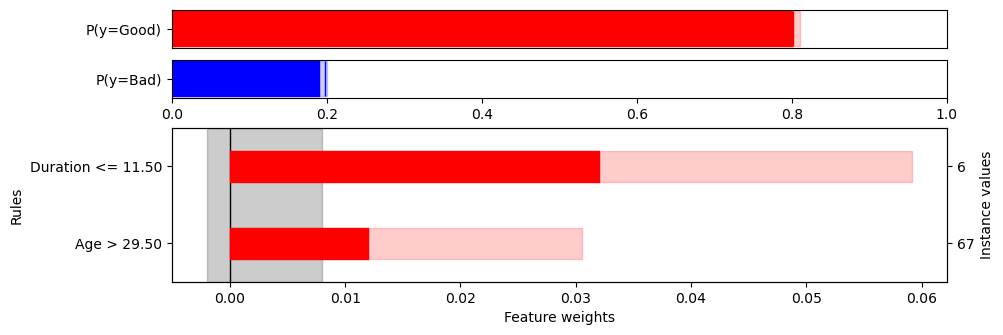

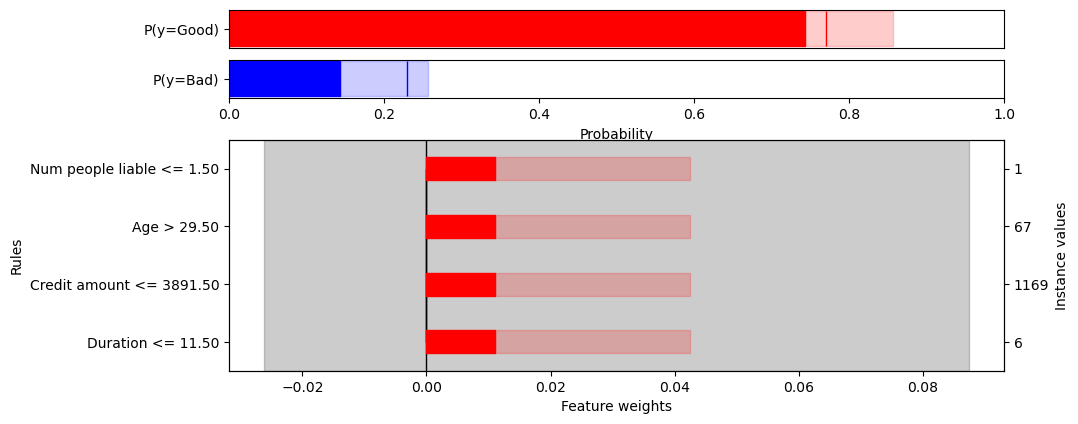

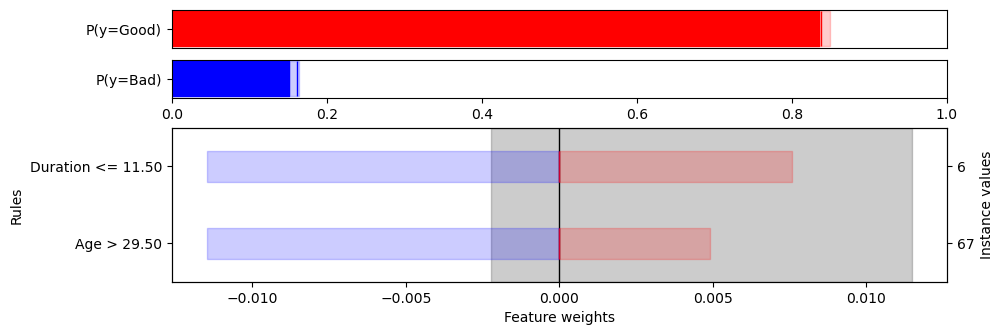

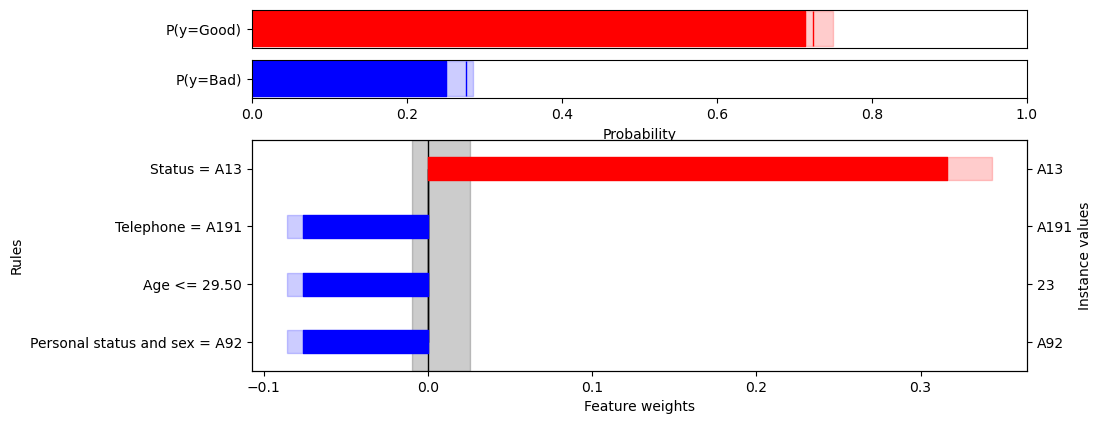

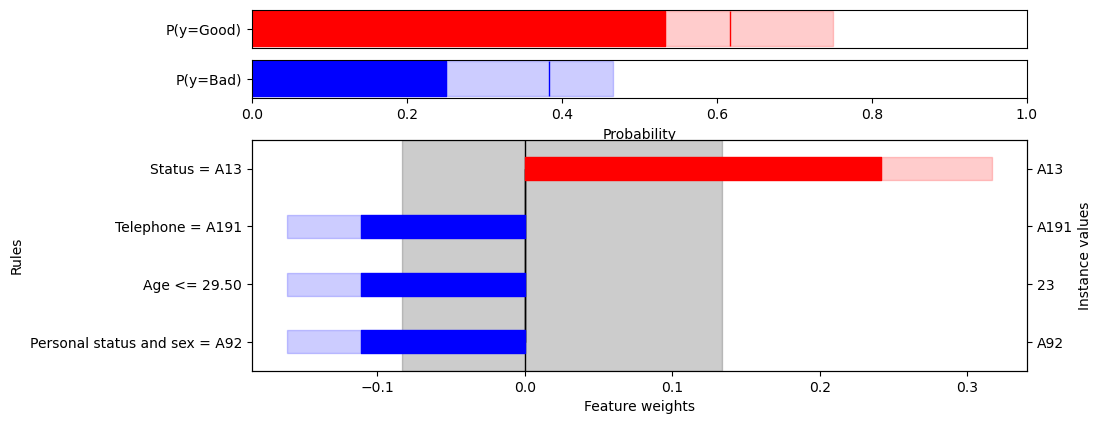

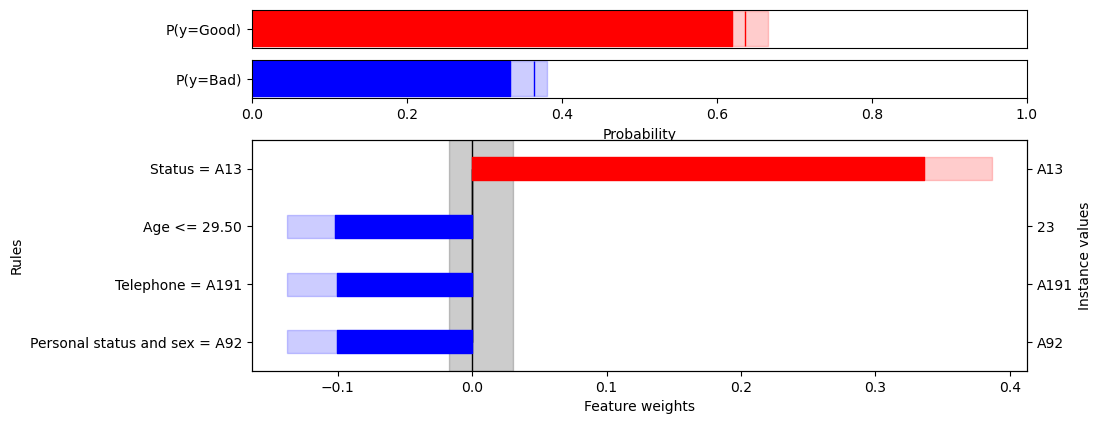

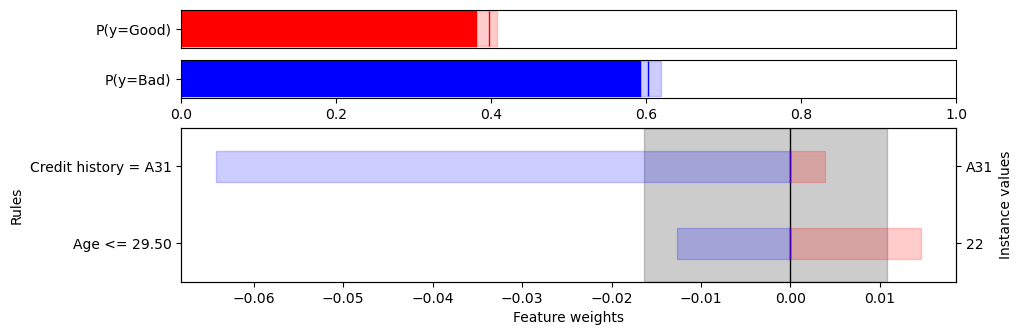

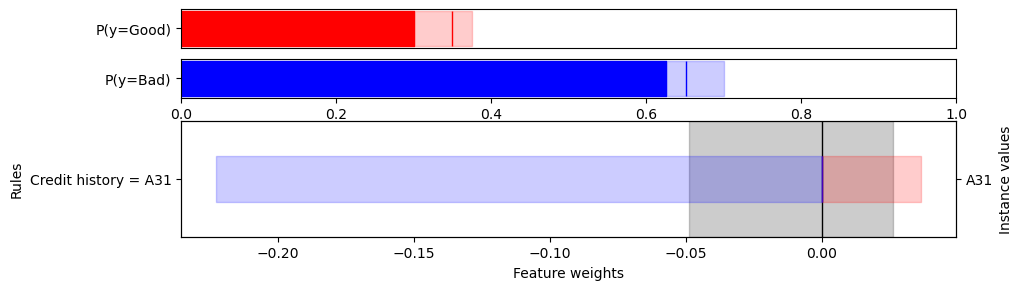

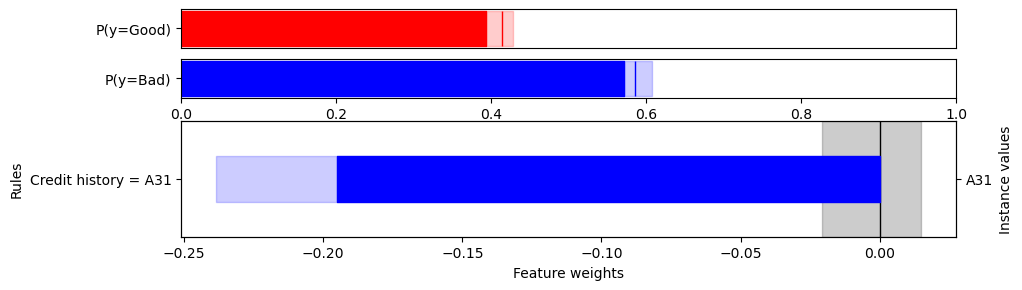

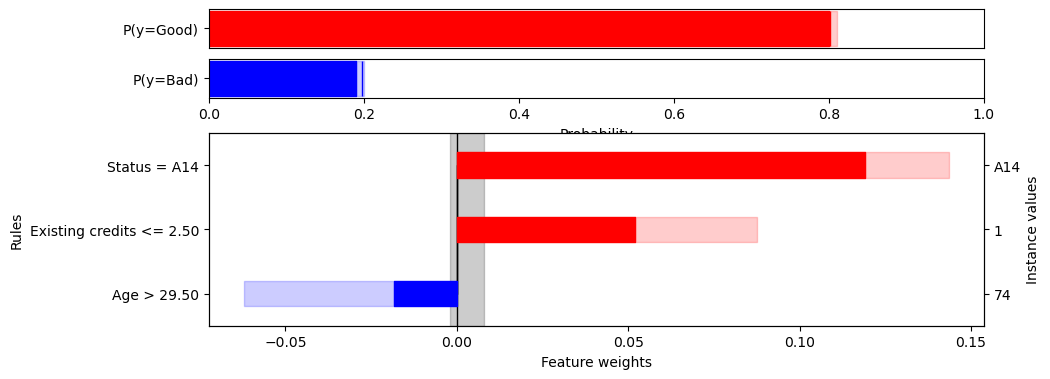

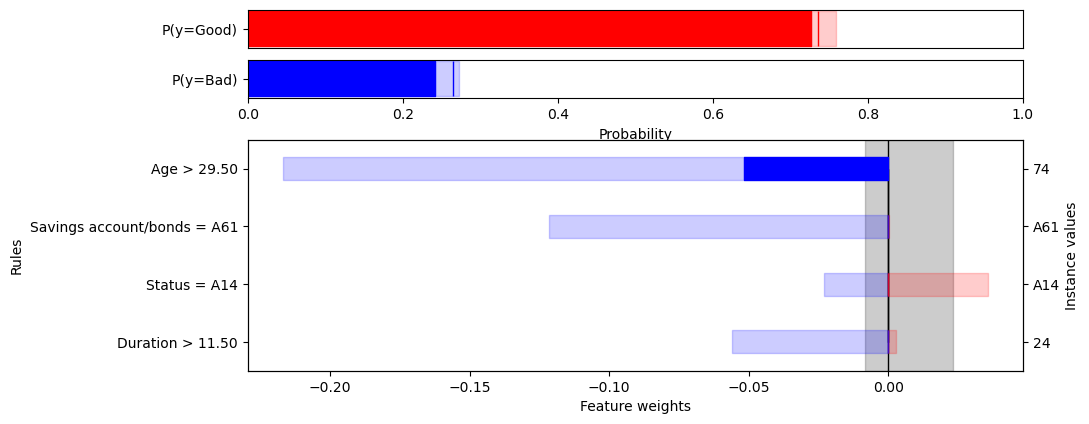

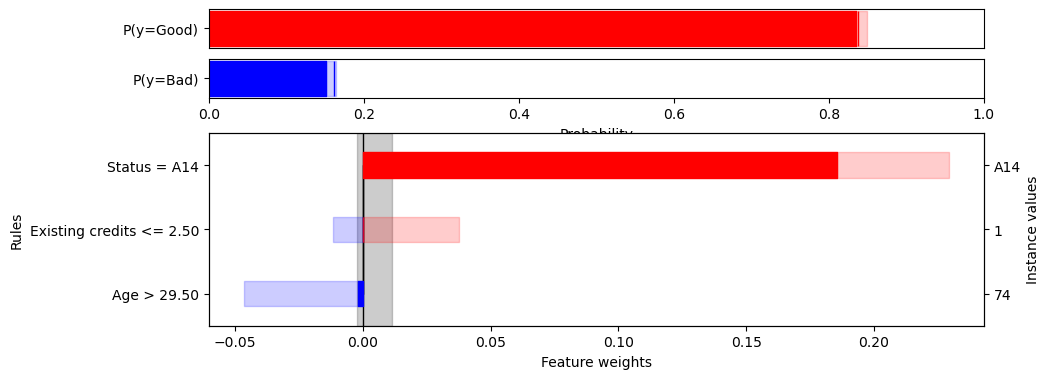

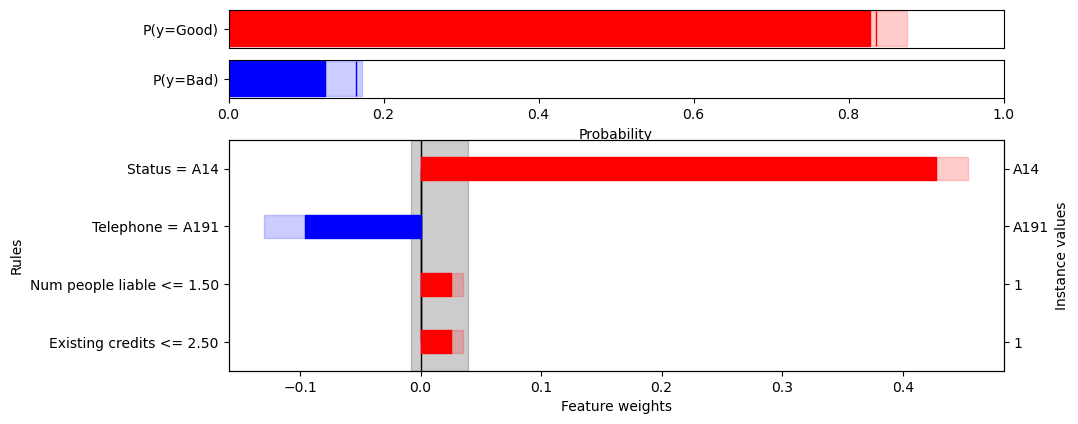

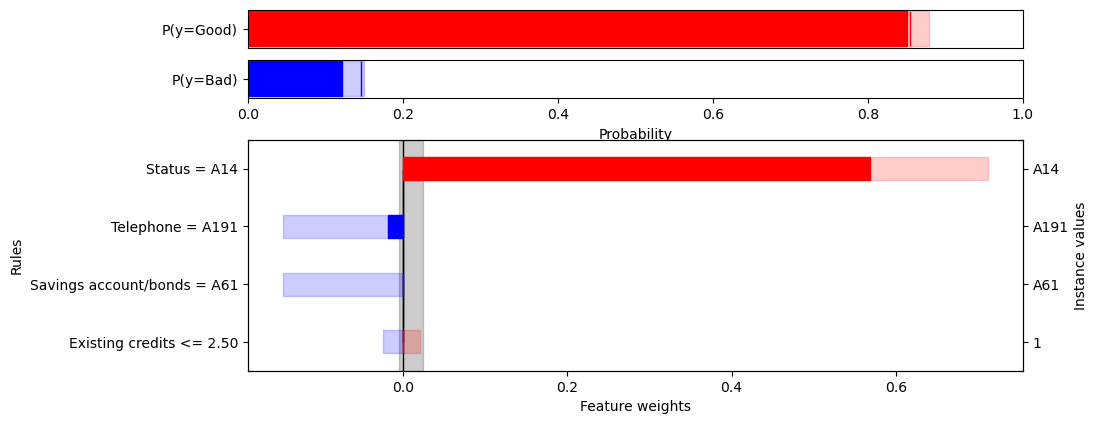

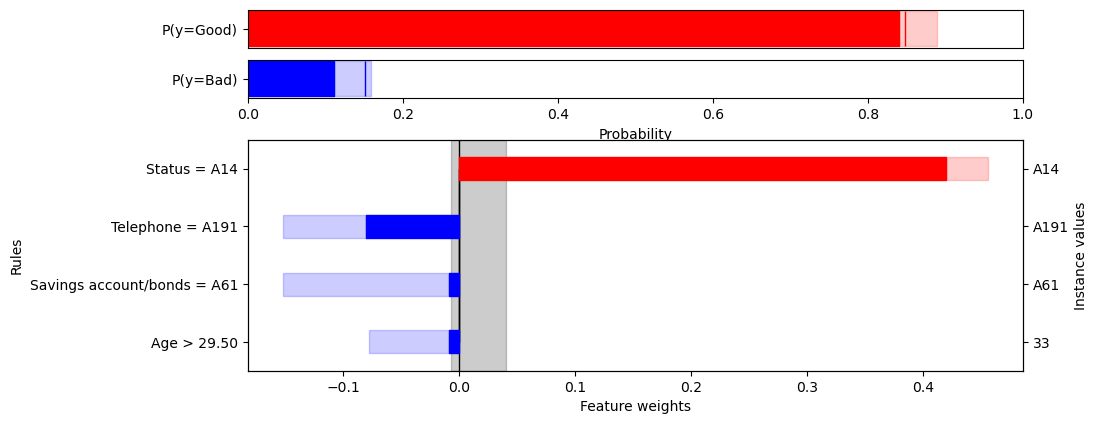

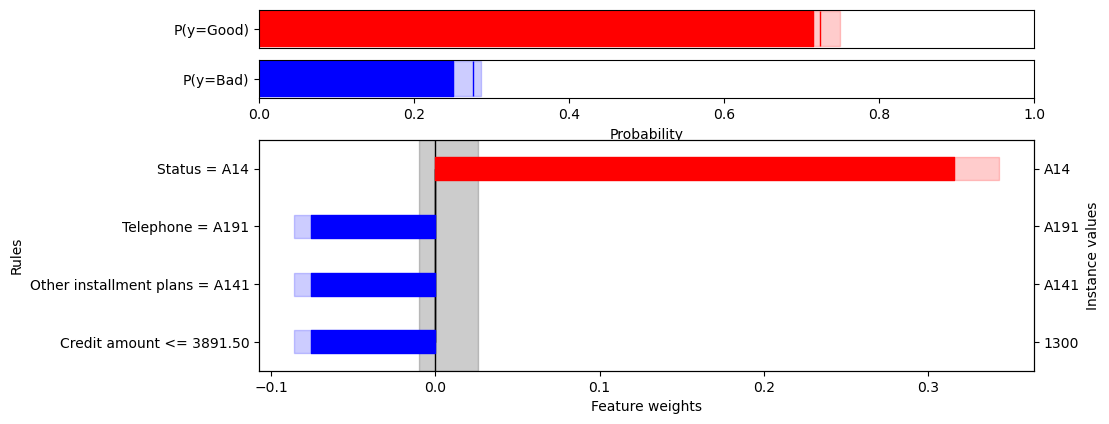

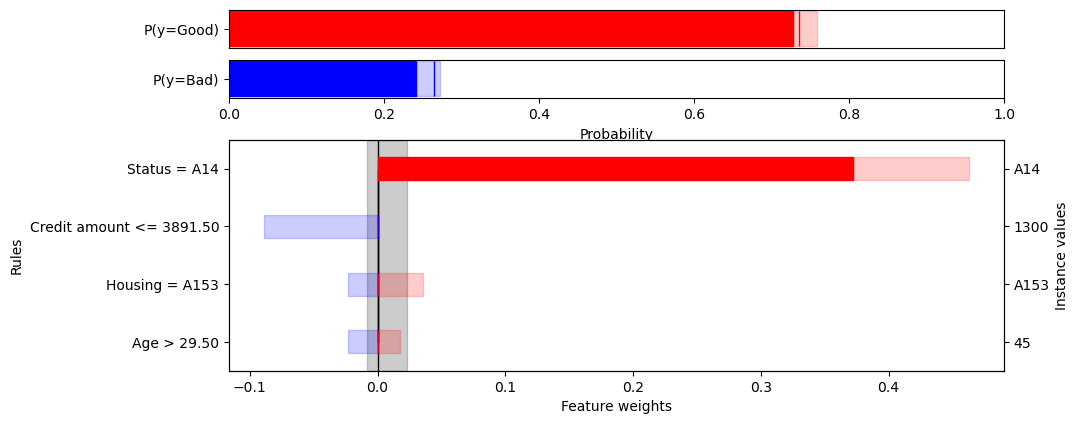

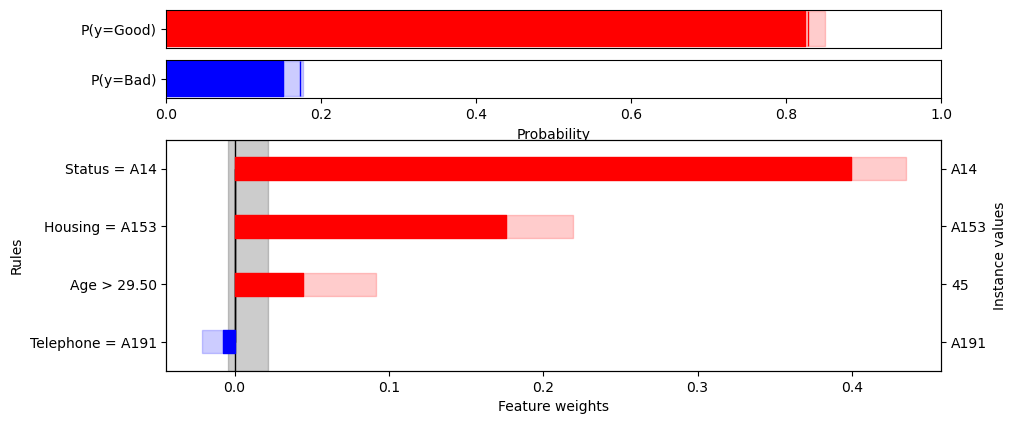

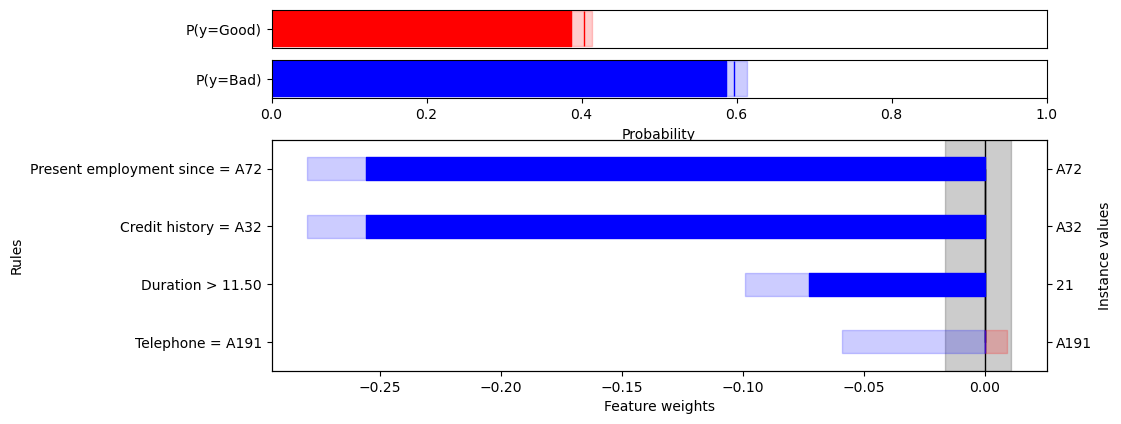

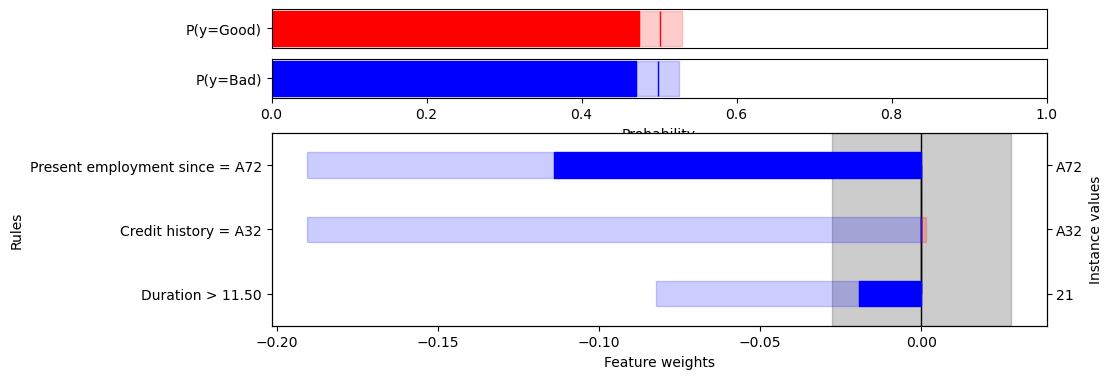

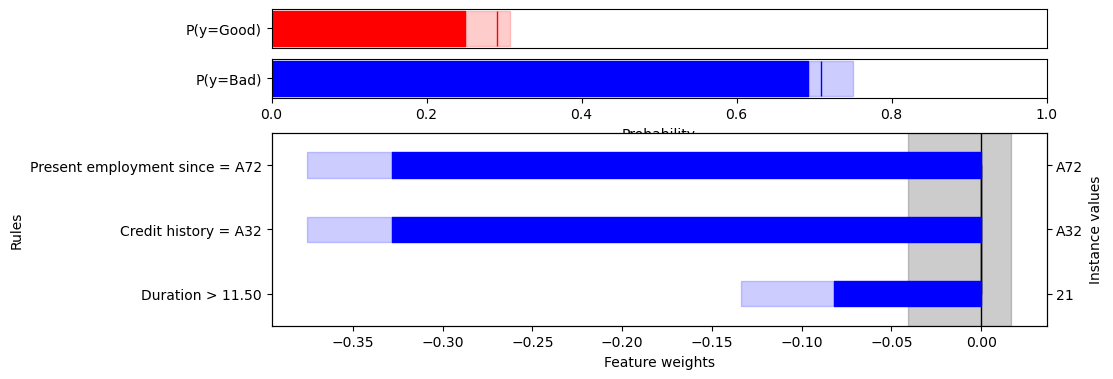

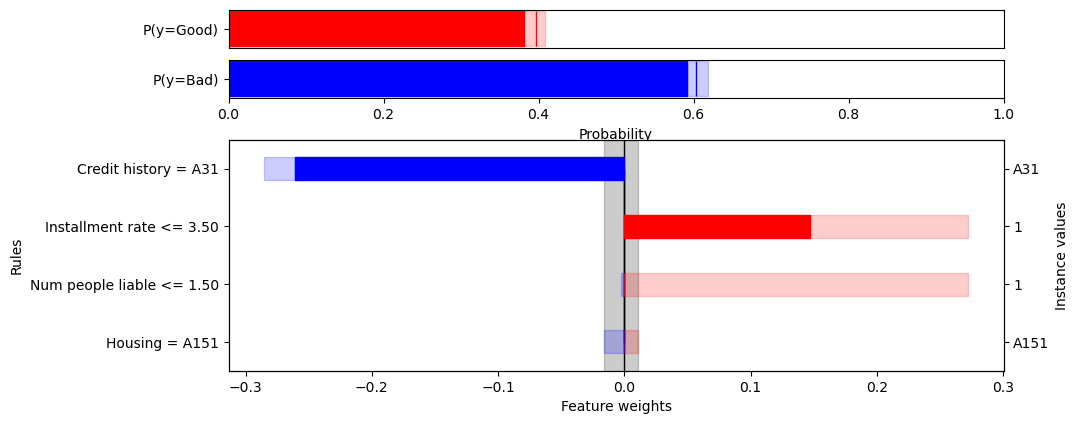

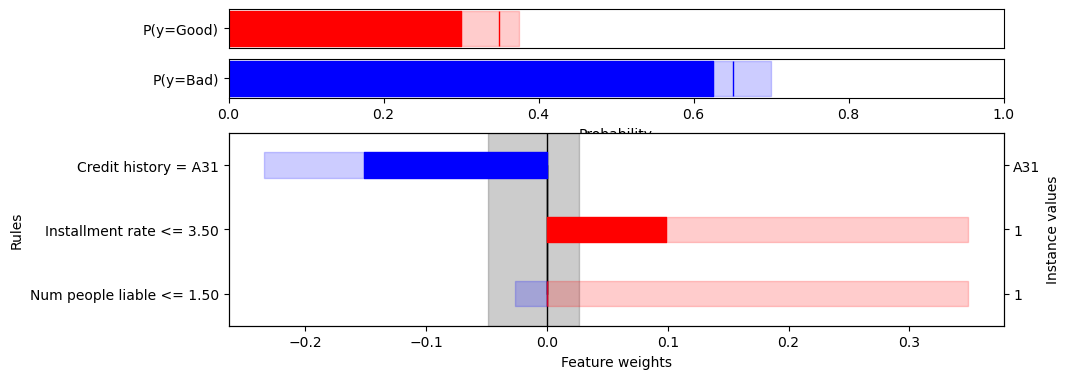

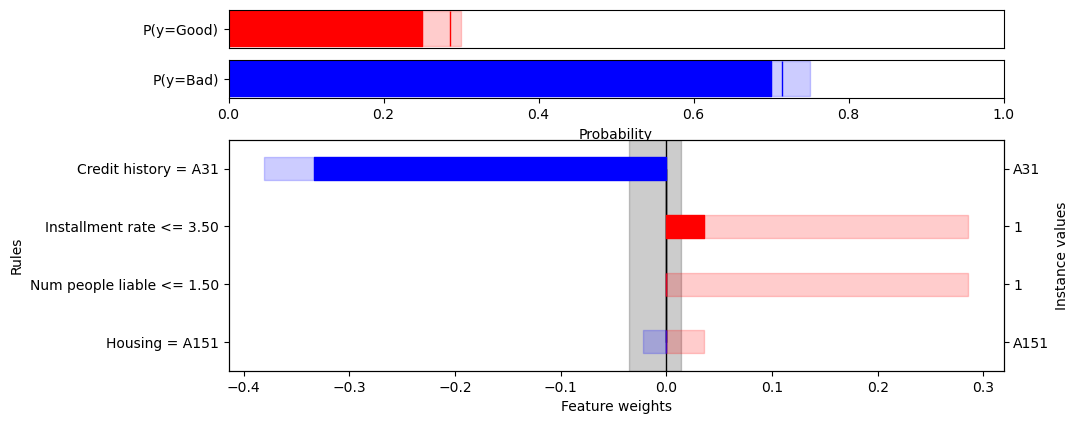

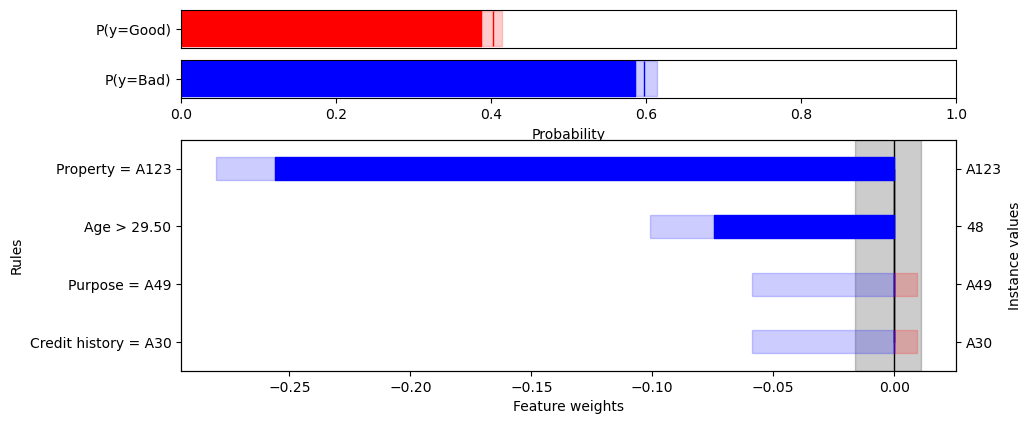

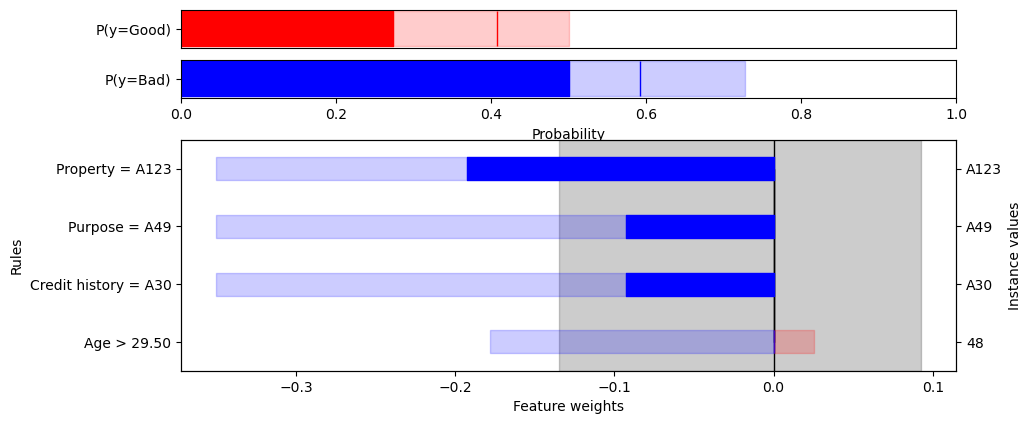

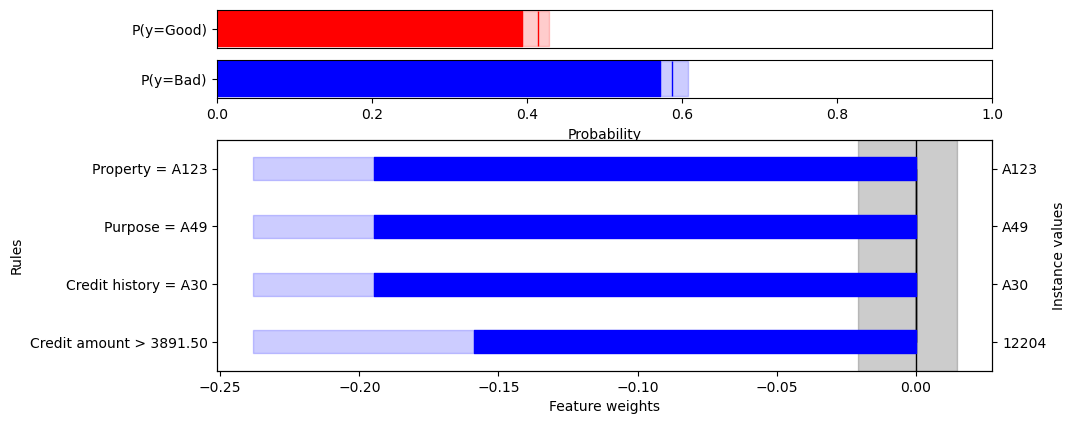

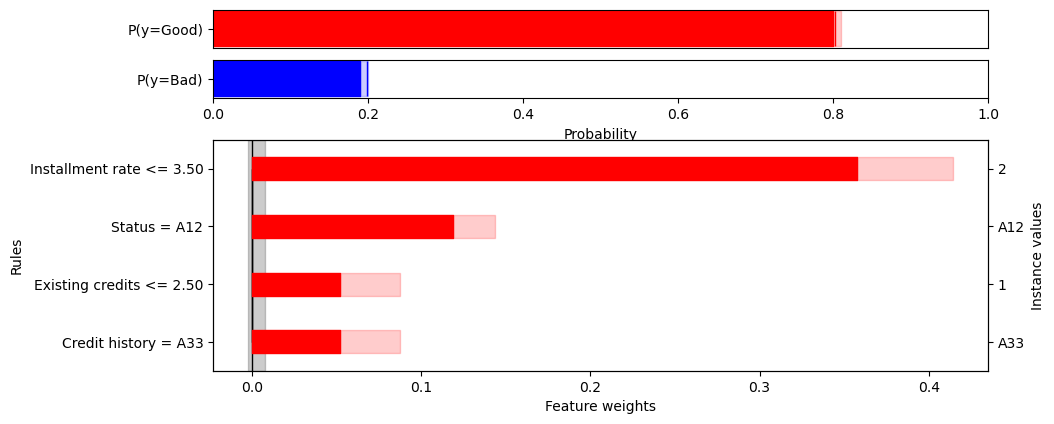

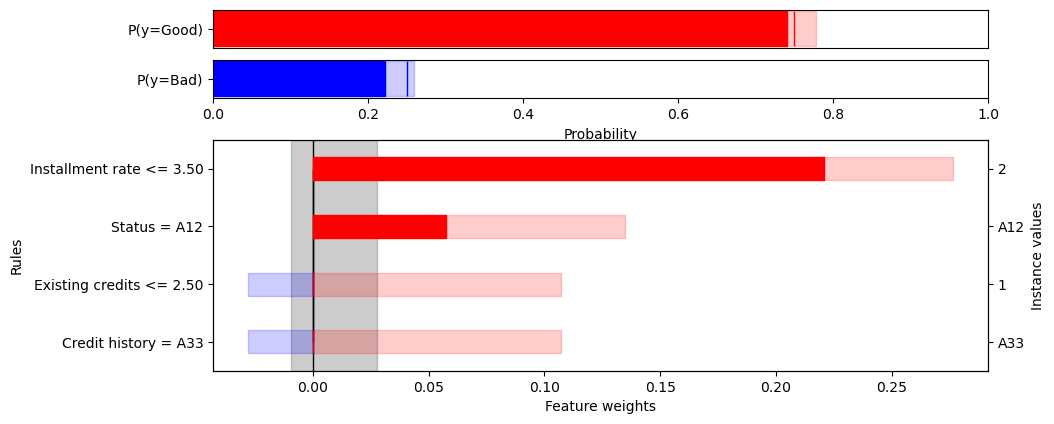

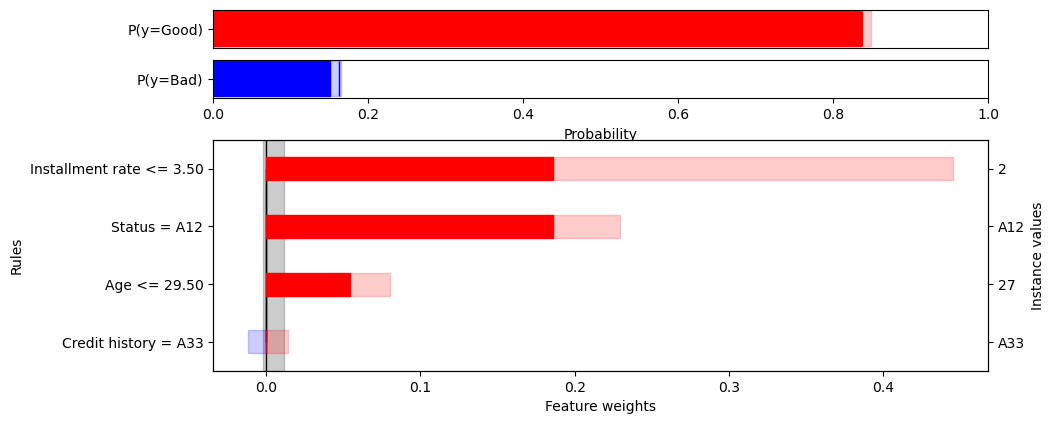

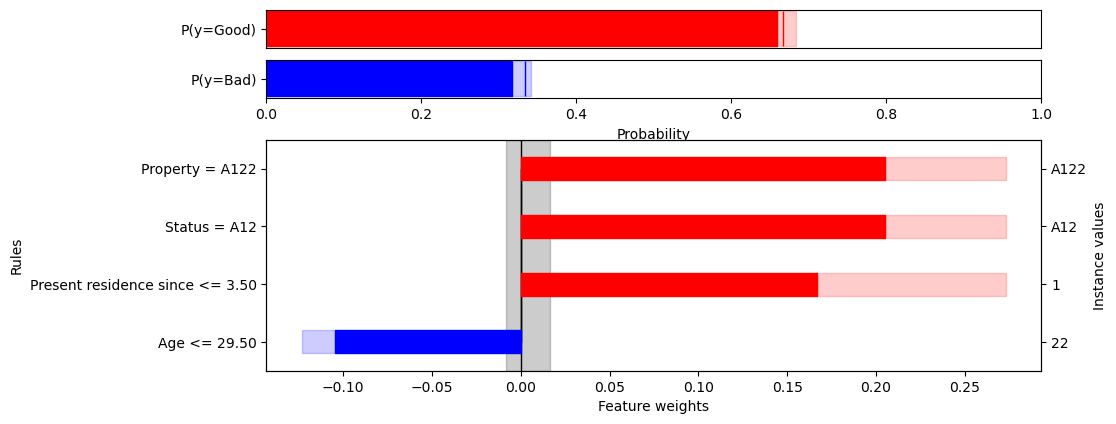

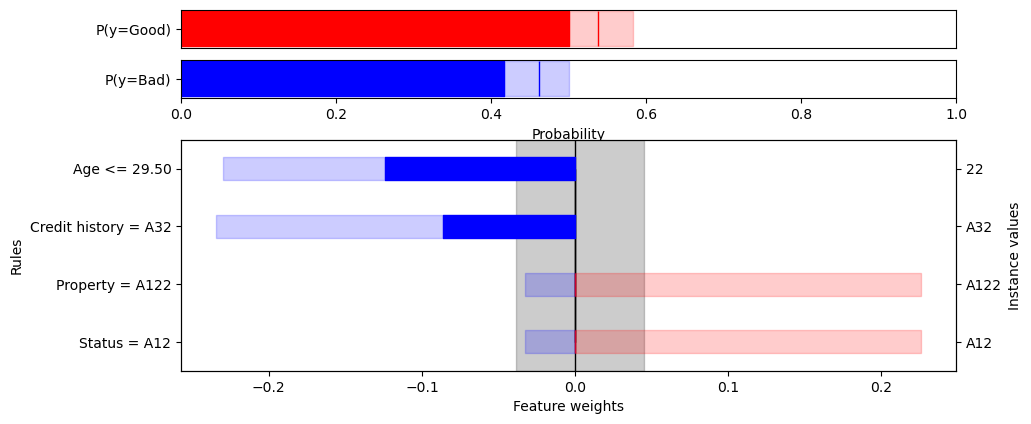

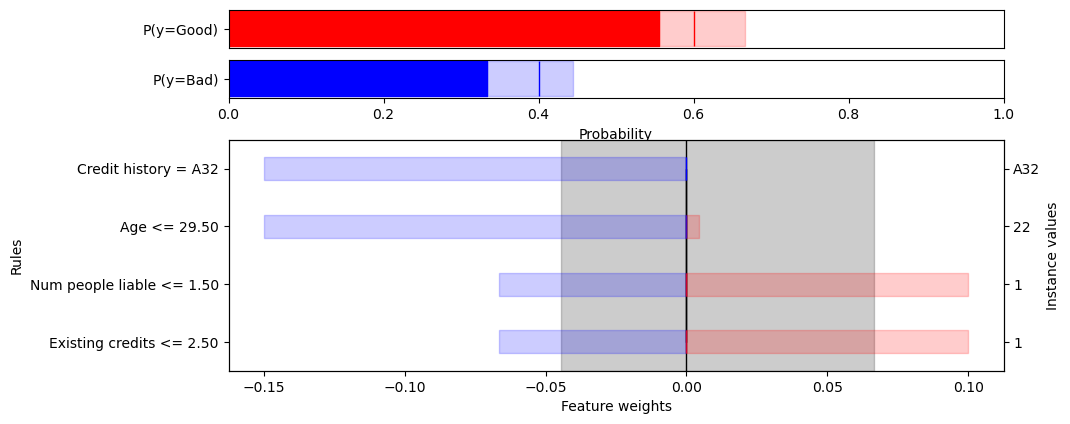

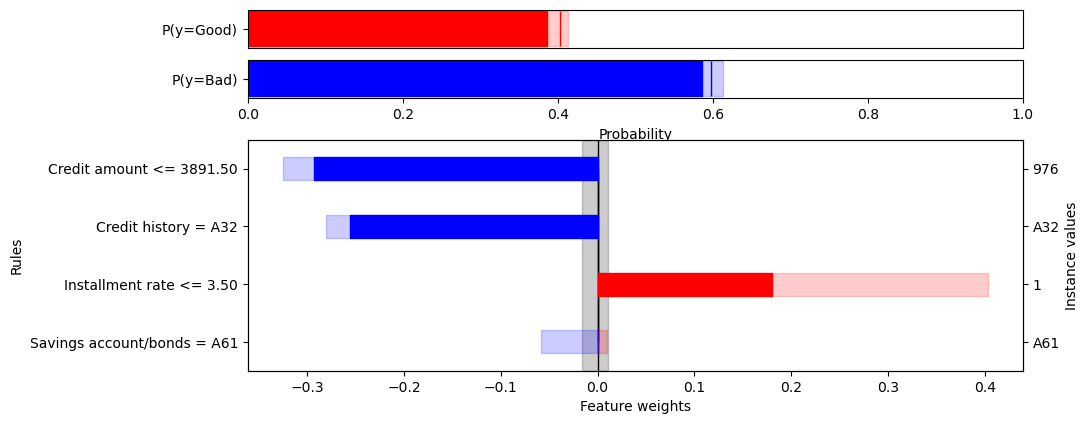

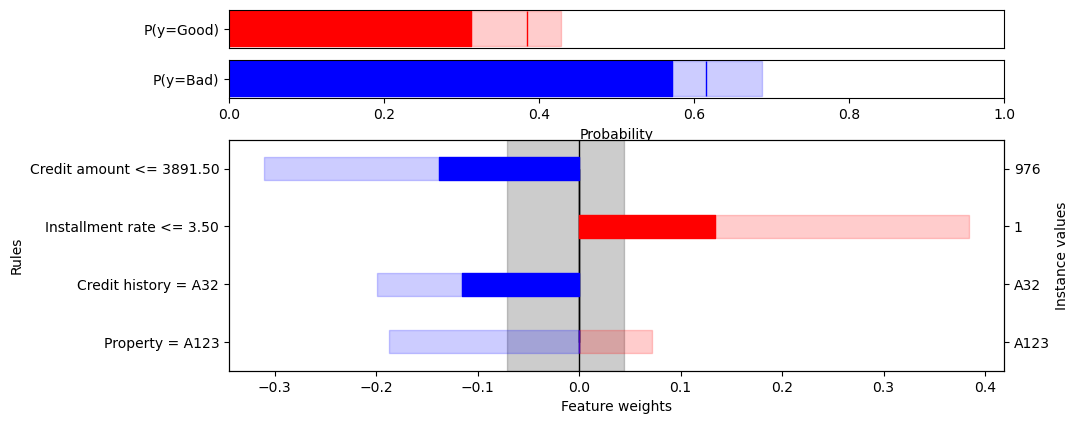

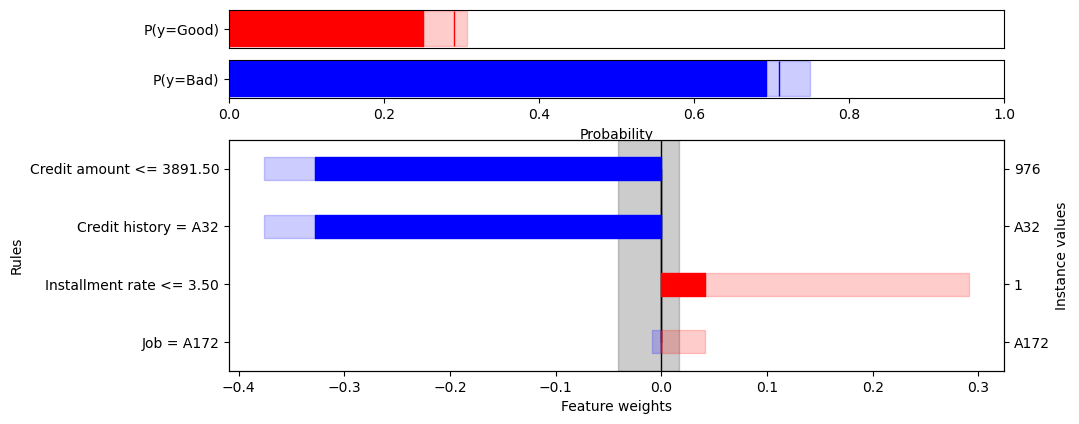

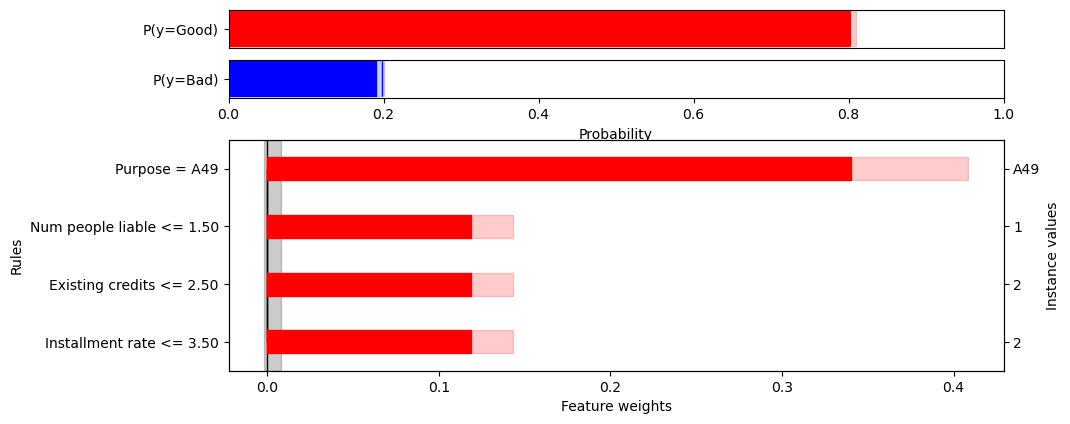

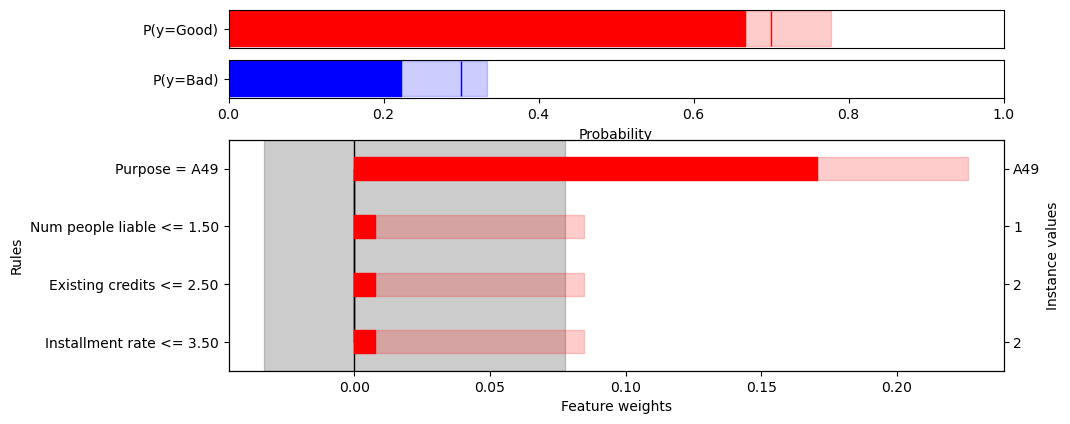

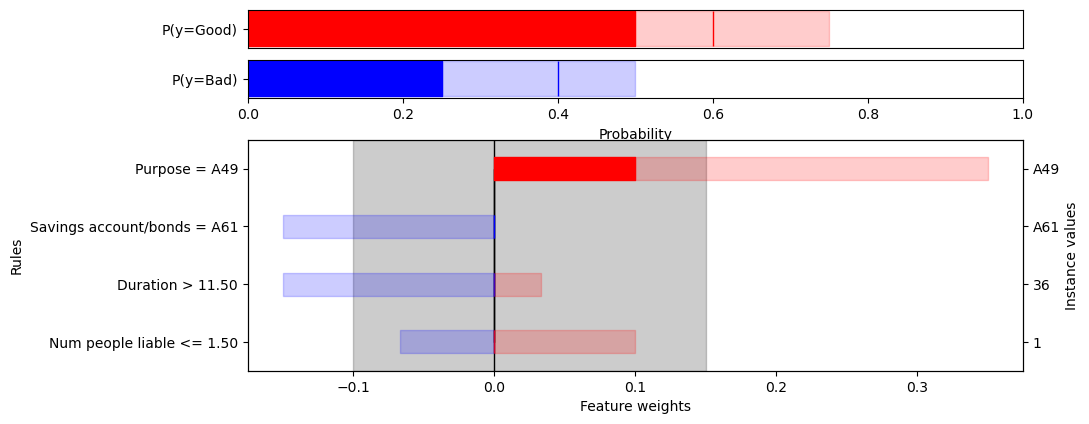

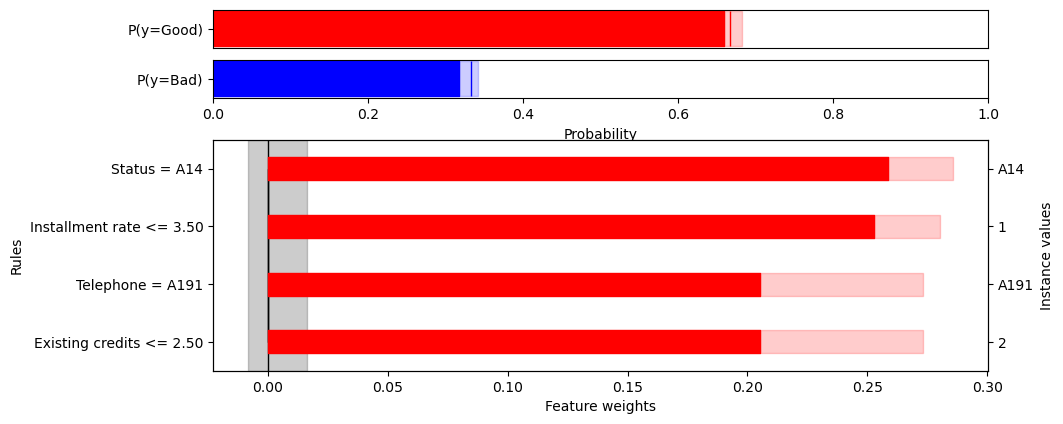

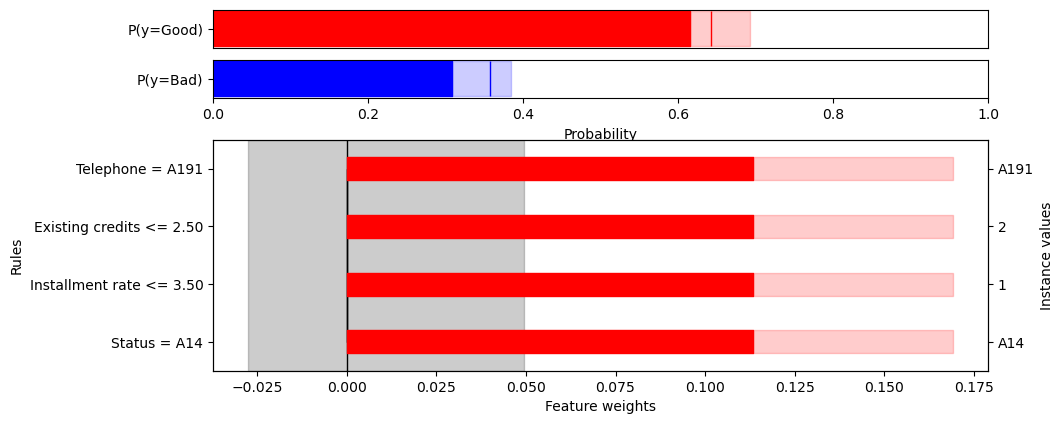

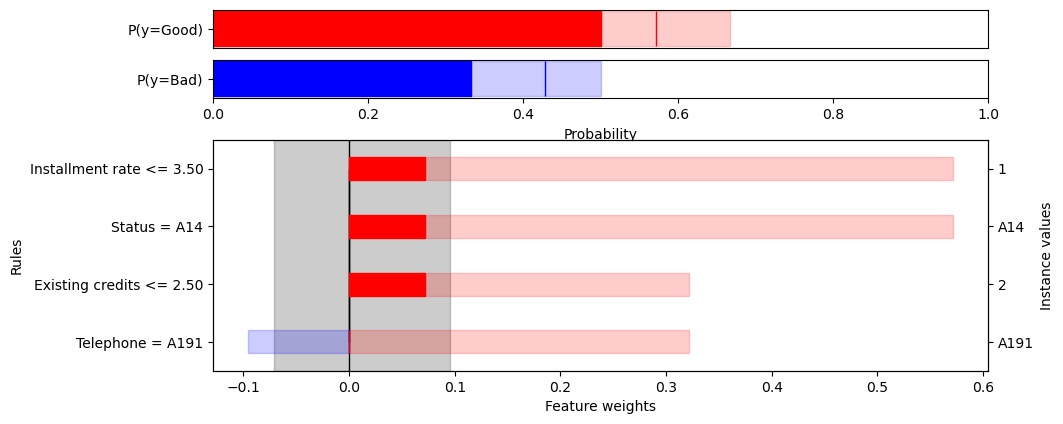

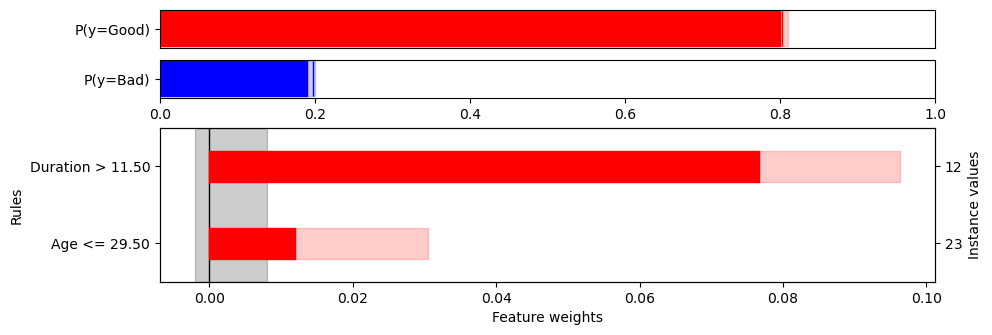

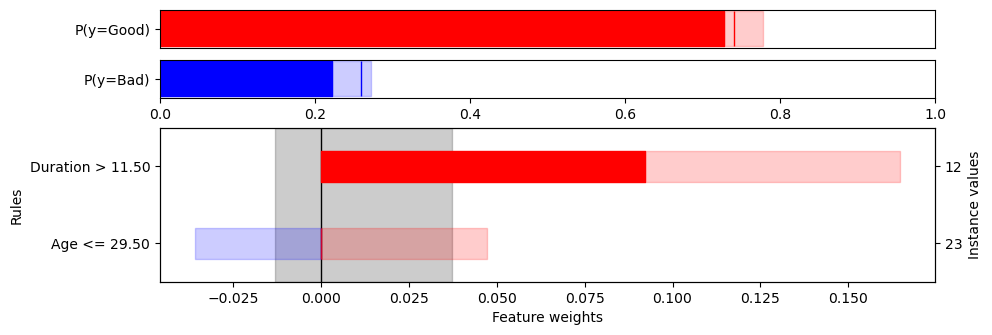

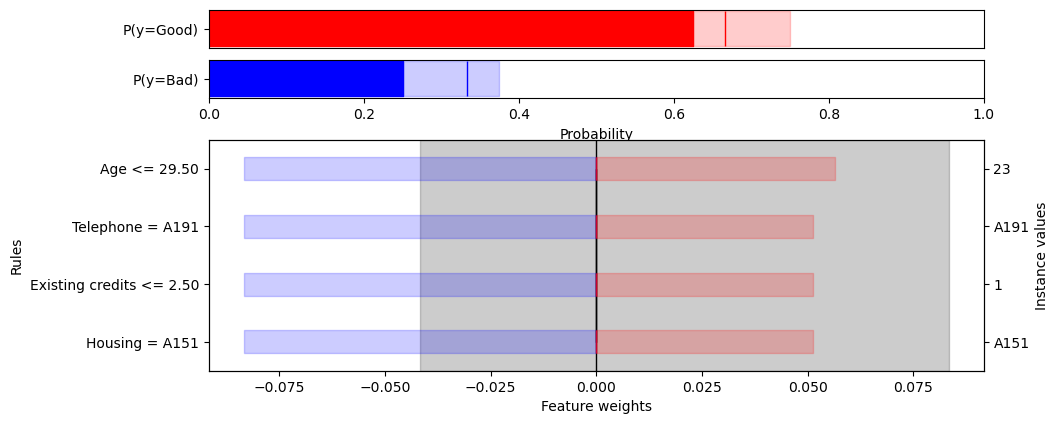

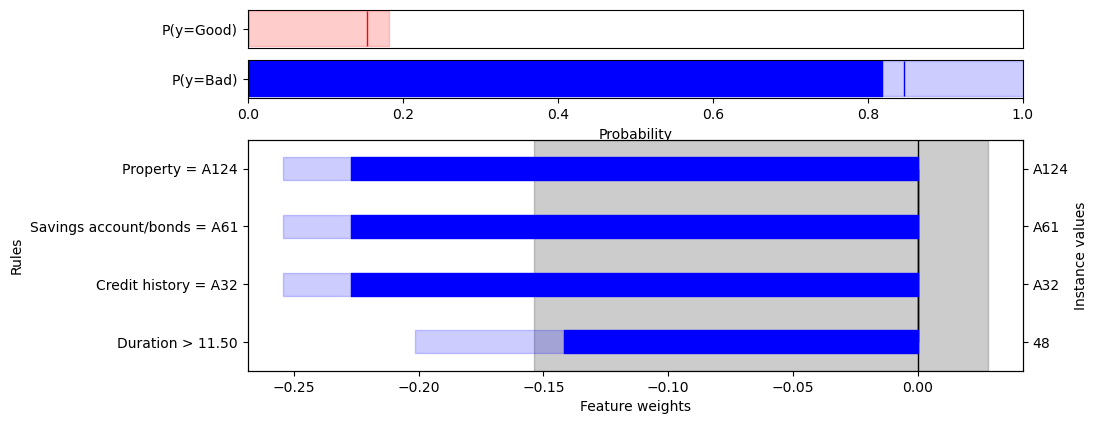

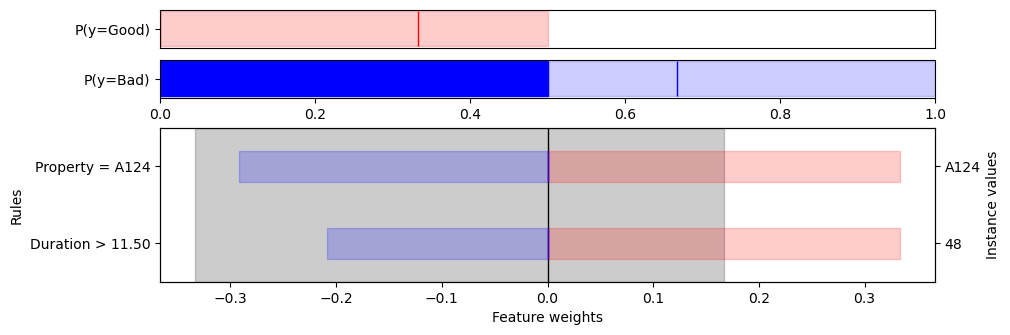

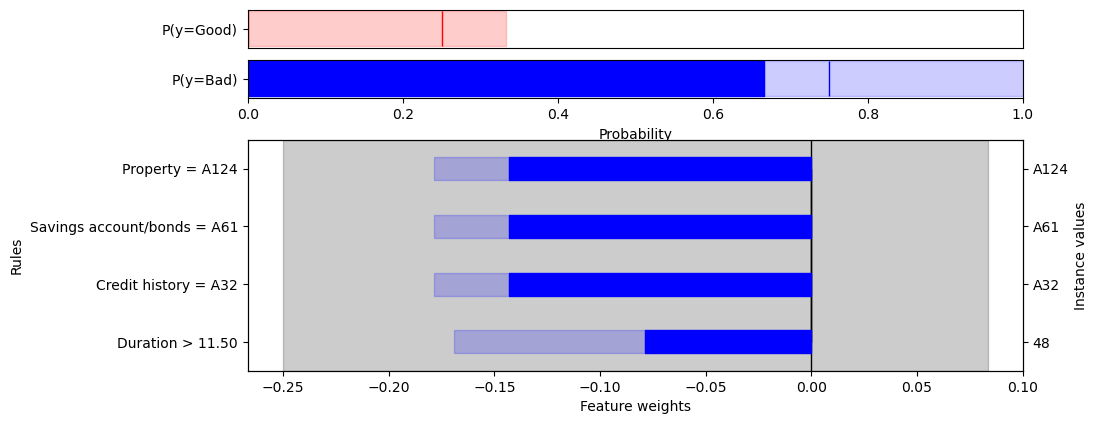

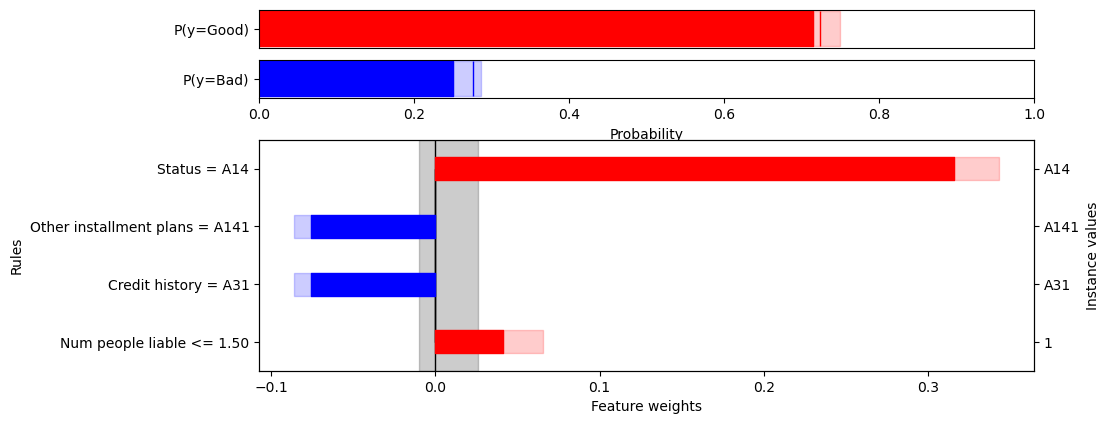

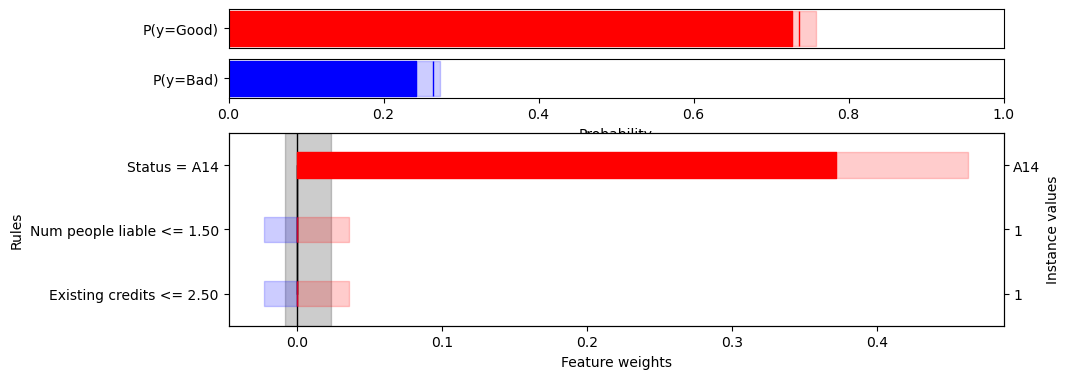

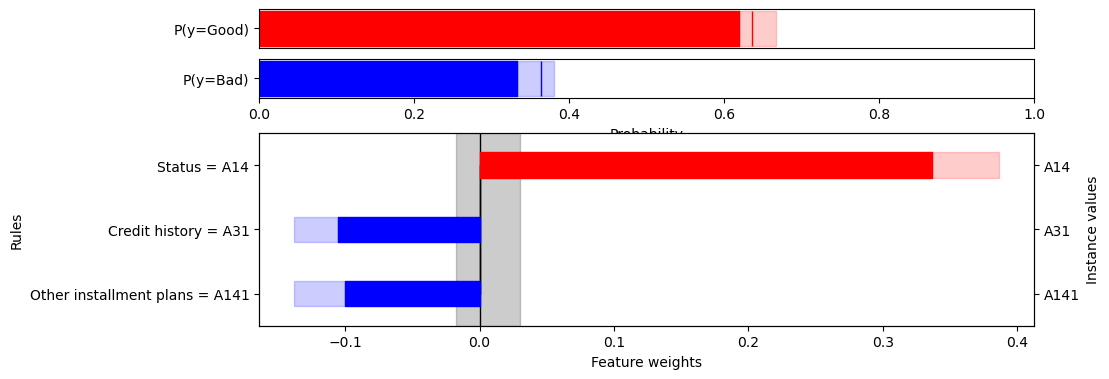

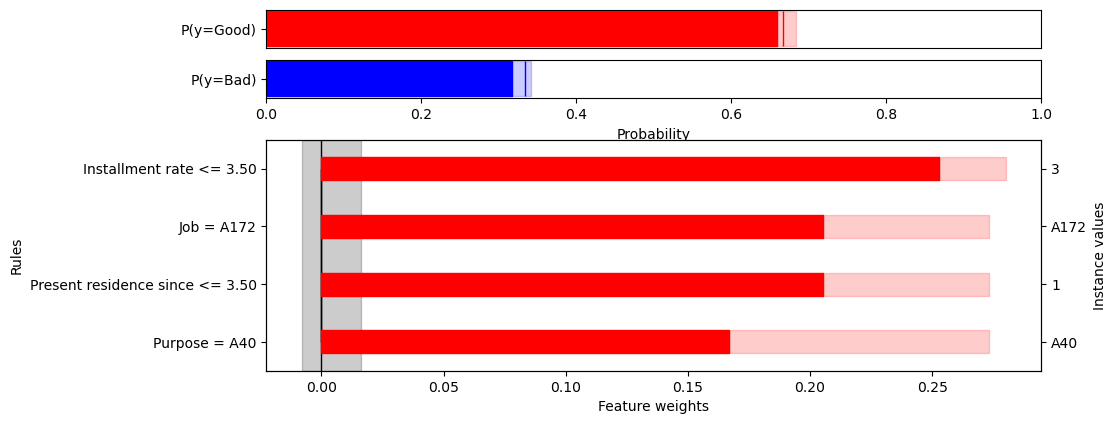

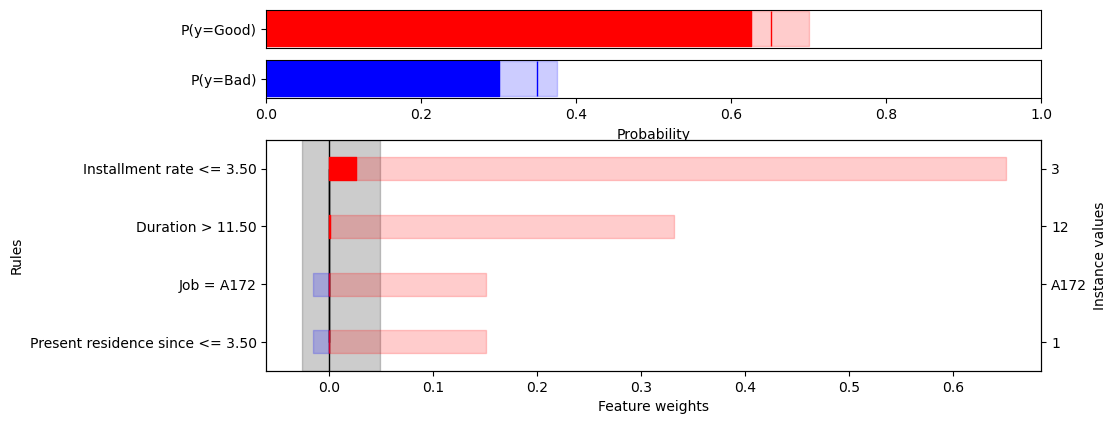

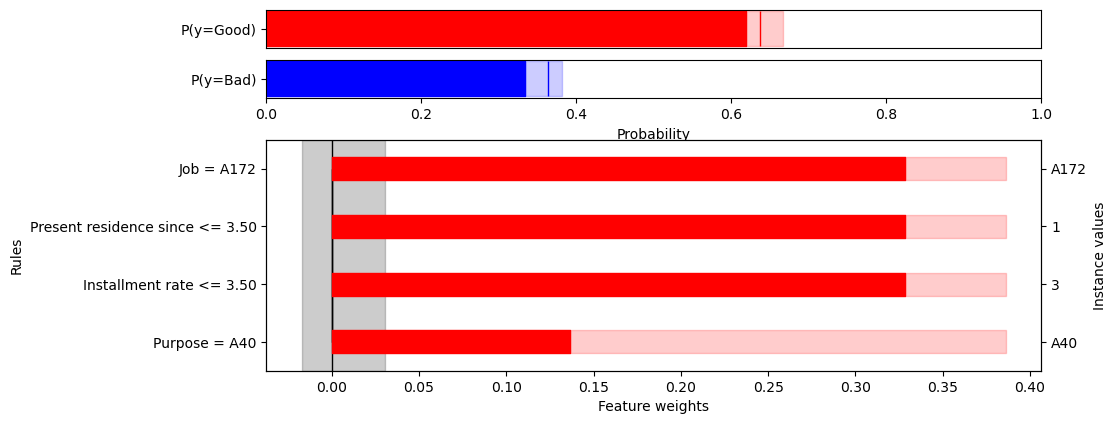

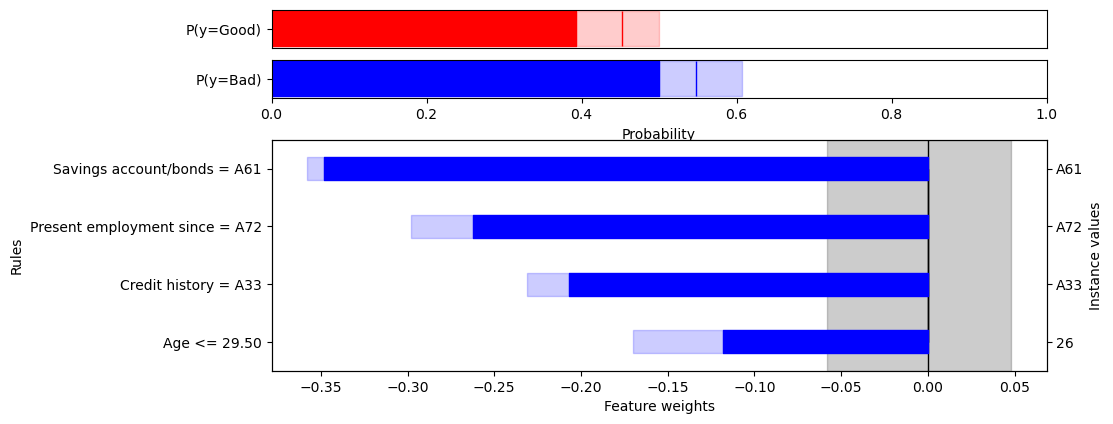

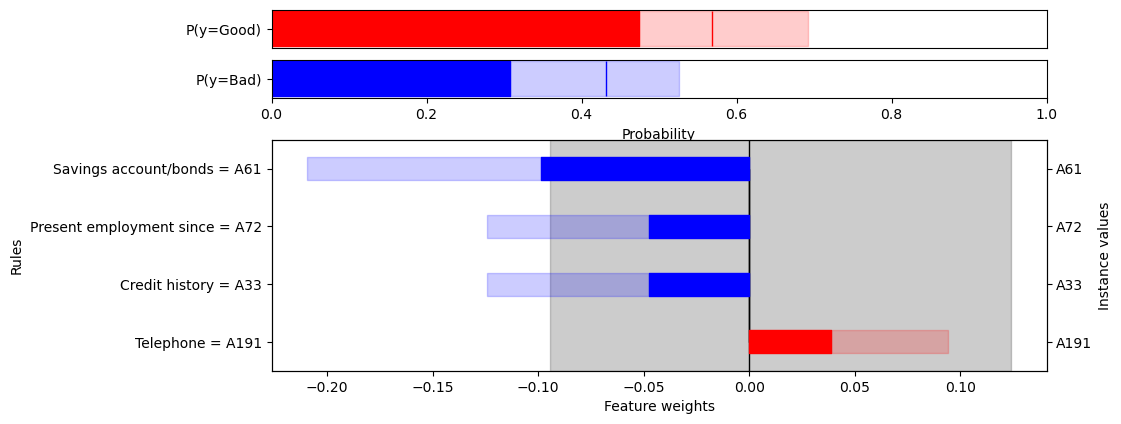

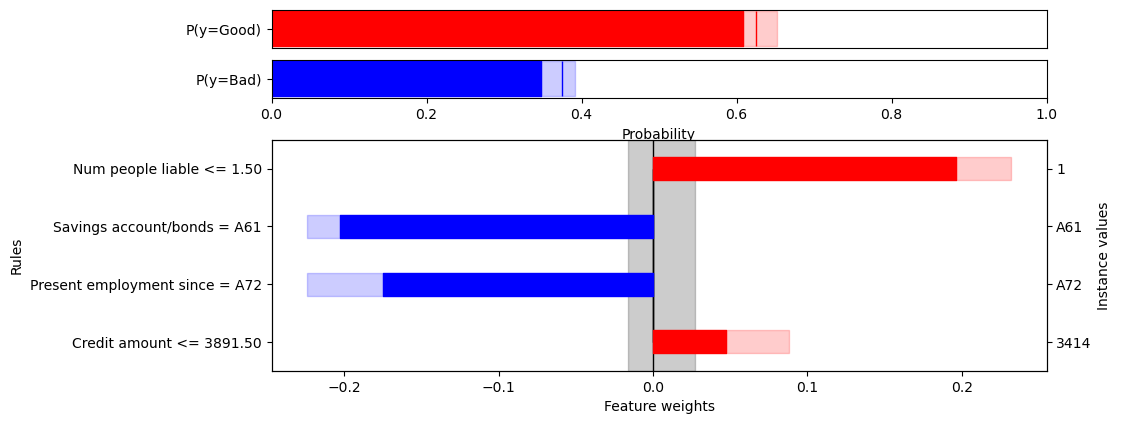

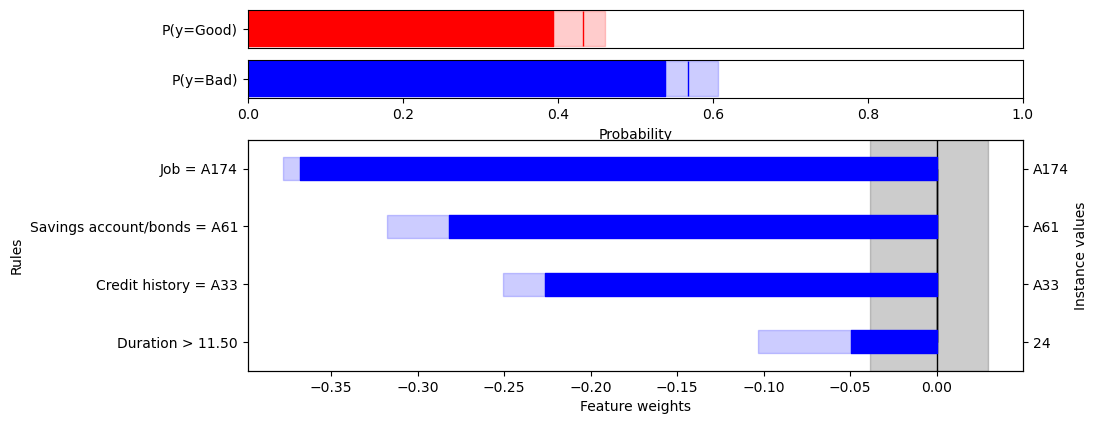

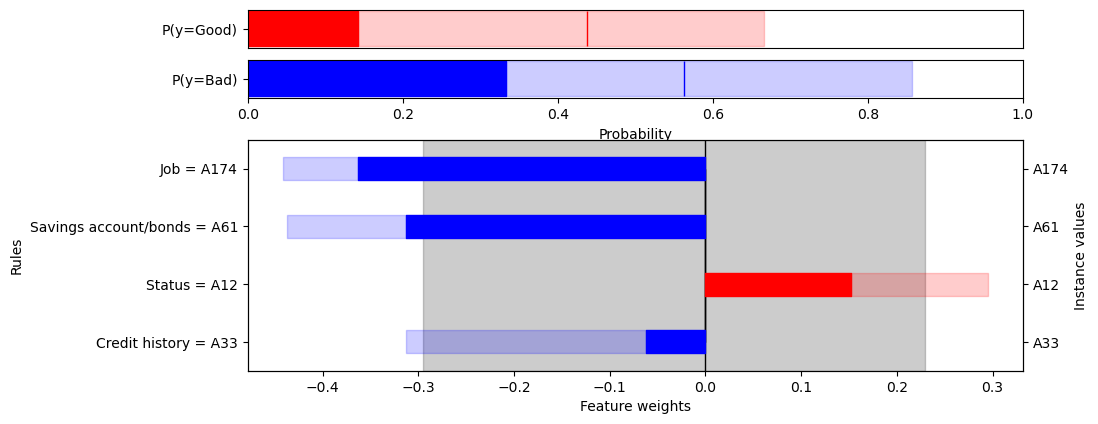

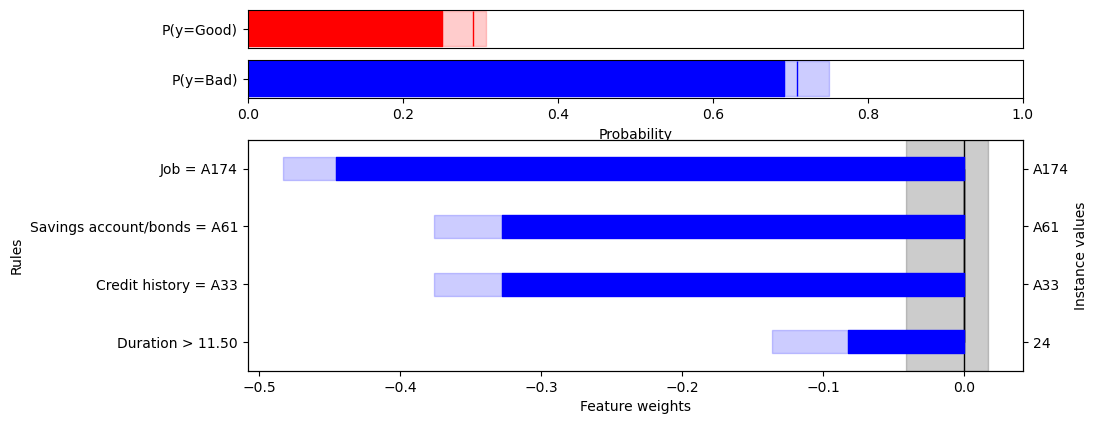

In [172]:
for i in range(len(testY)):     
    factual_explanation.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_age.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_sex.plot_explanation(i, n_features_to_show=4, uncertainty=True)

In [ ]:
counterfactual_explanation = ce.explain_counterfactual(testX)
counterfactual_explanation_age = ce_age.explain_counterfactual(testX, bins=age_test_bin)
counterfactual_explanation_sex = ce_sex.explain_counterfactual(testX, bins=testX[:,sex])

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:1647: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:1647: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


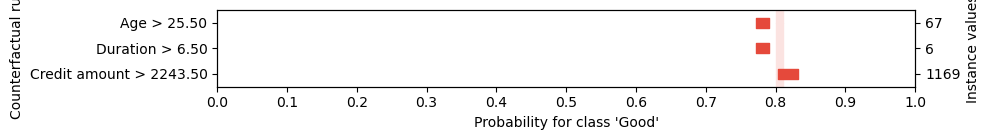

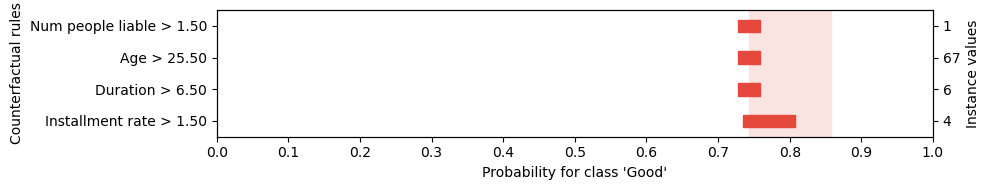

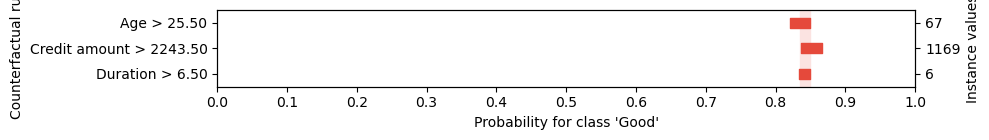

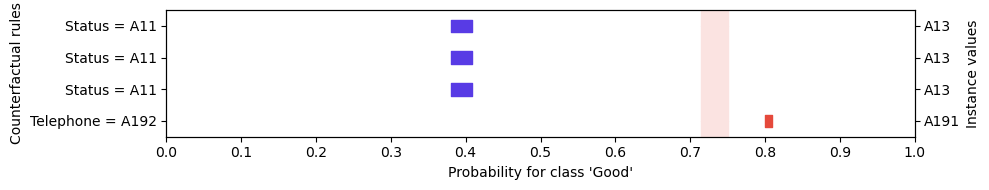

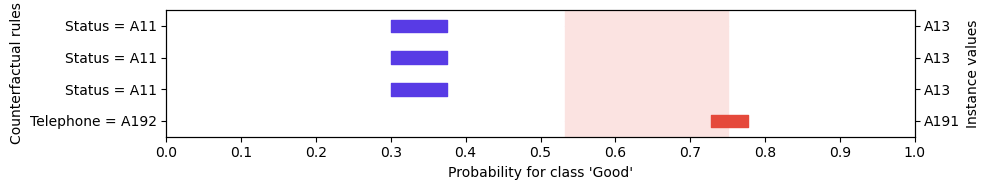

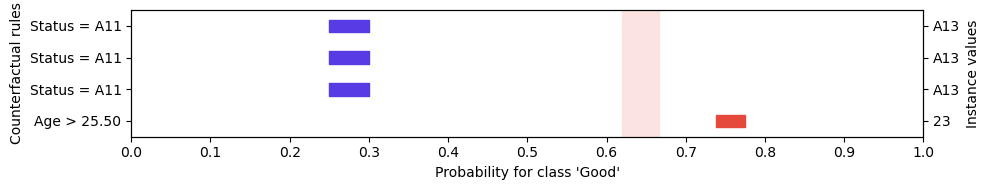

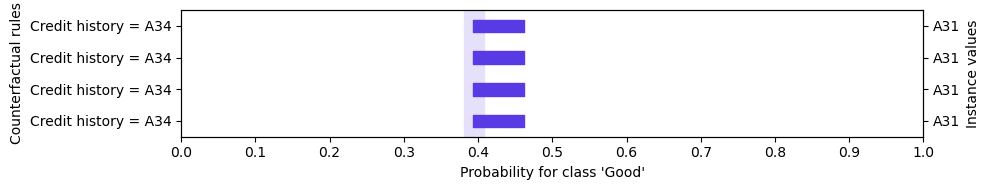

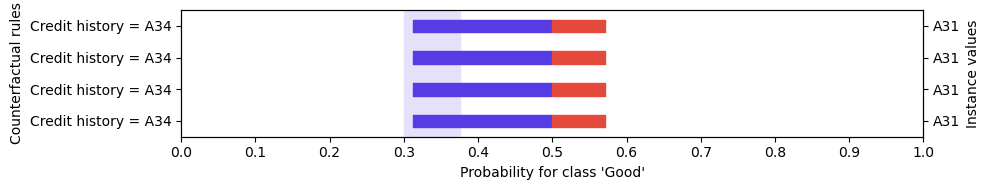

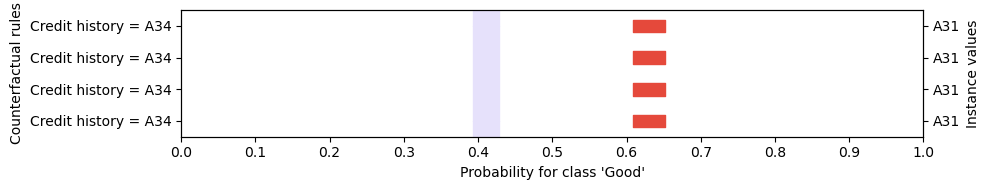

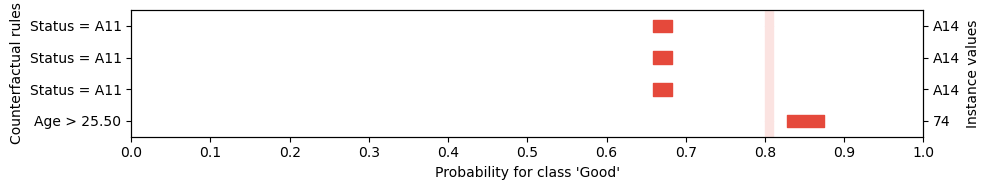

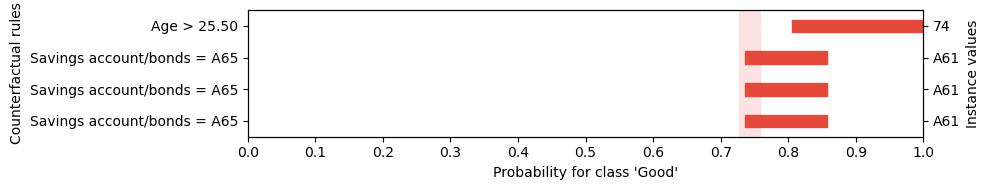

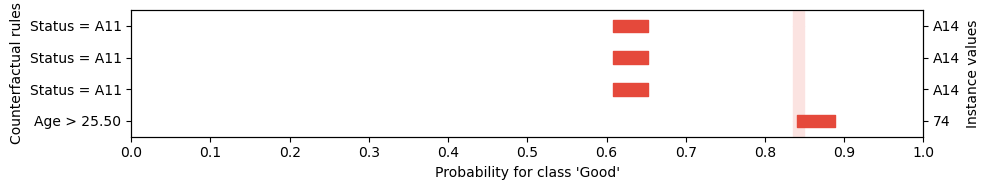

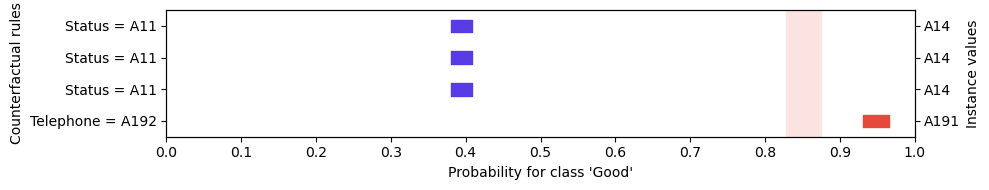

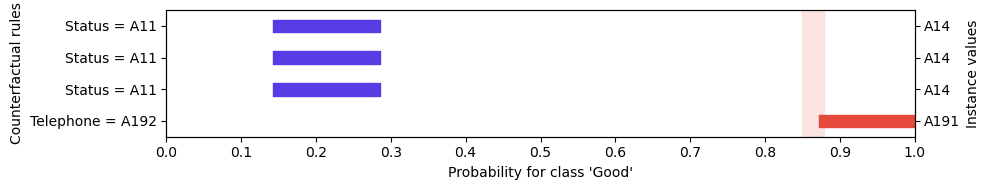

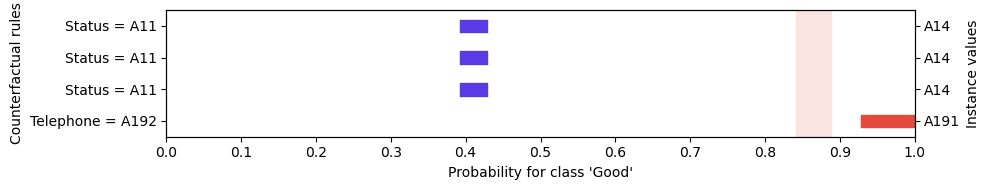

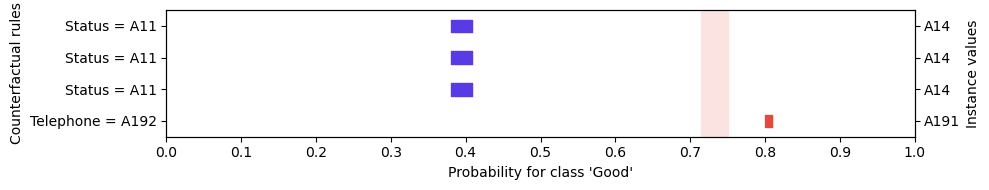

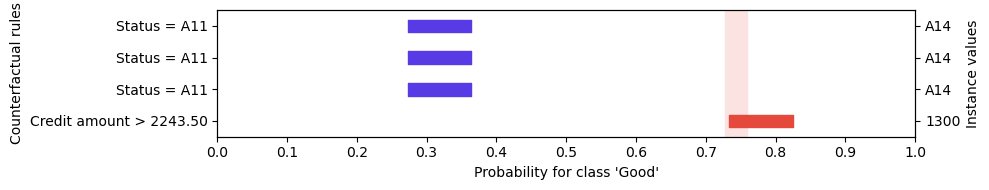

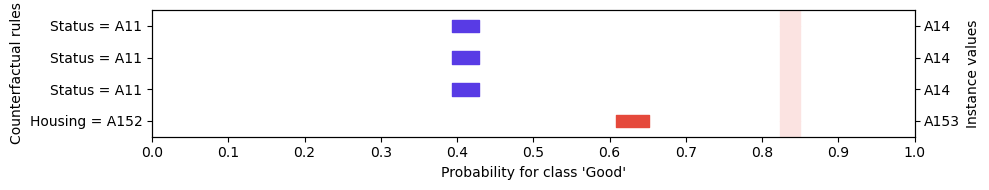

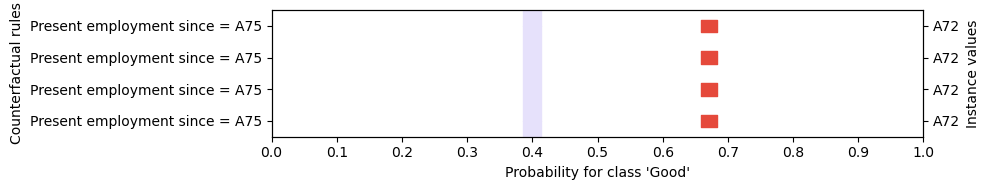

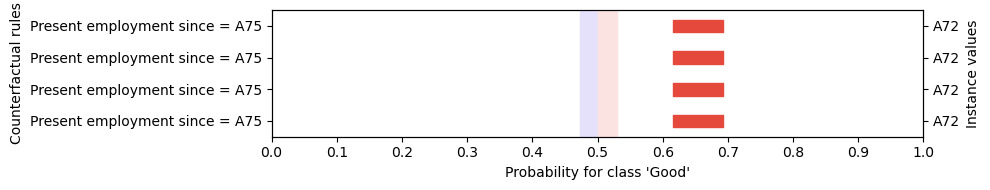

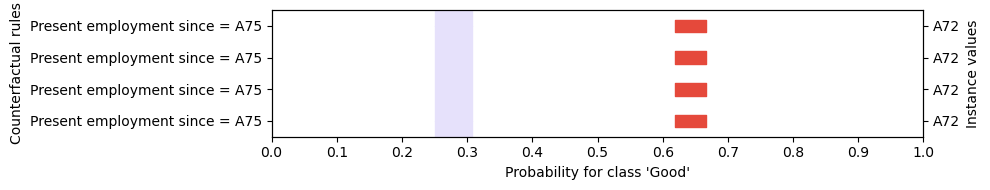

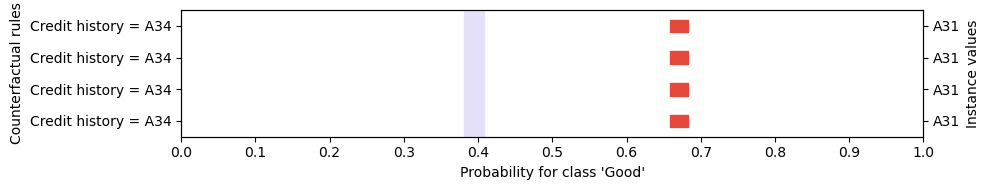

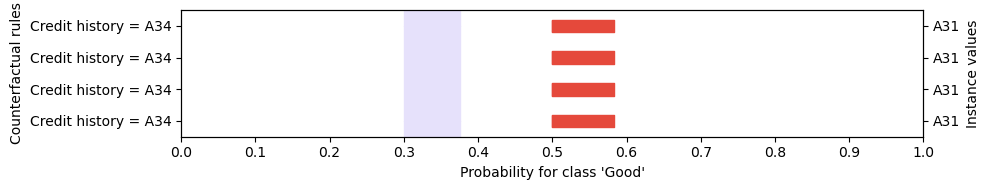

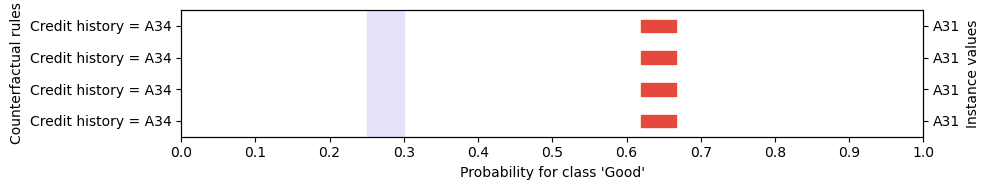

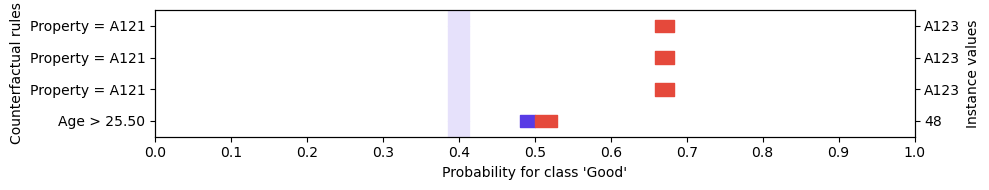

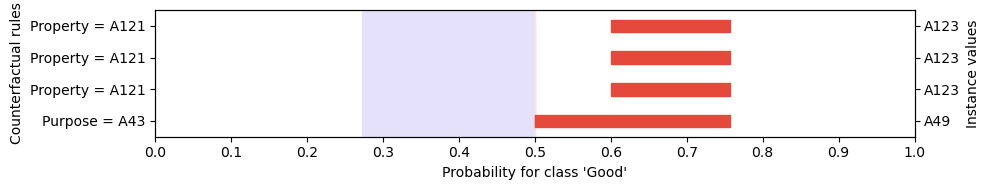

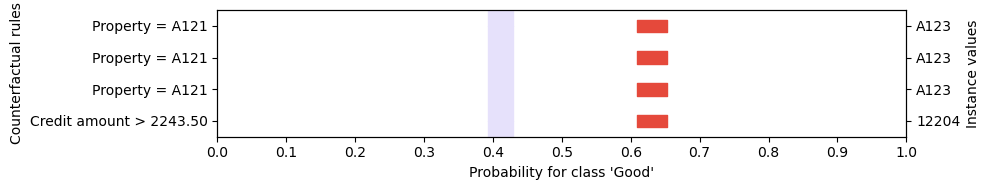

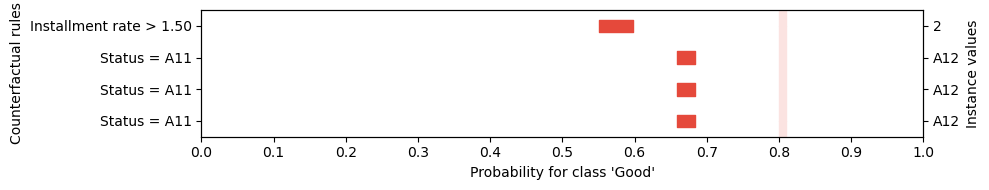

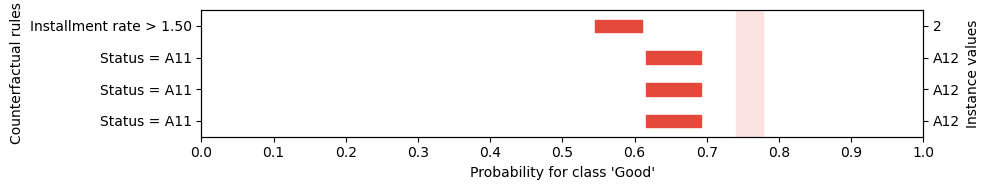

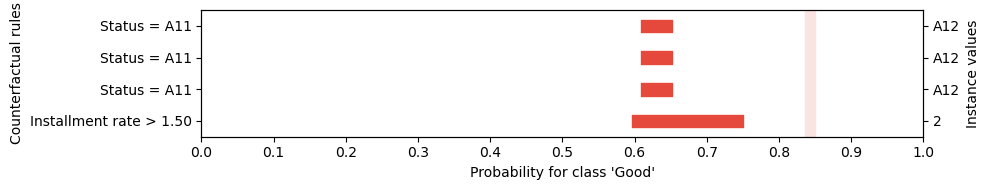

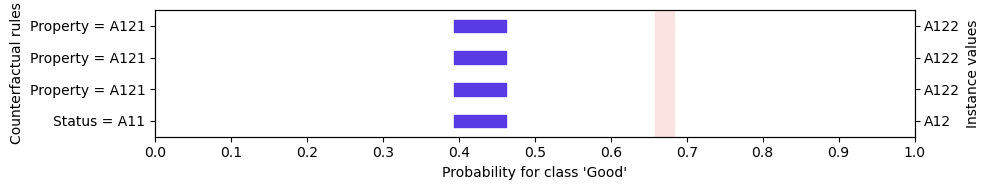

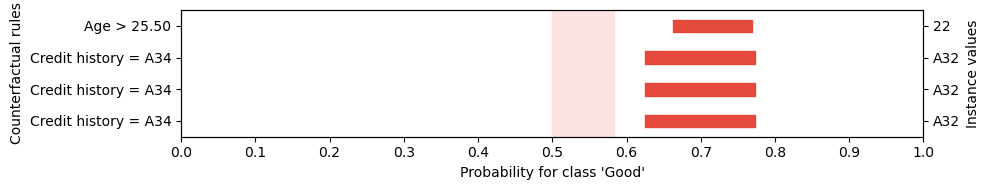

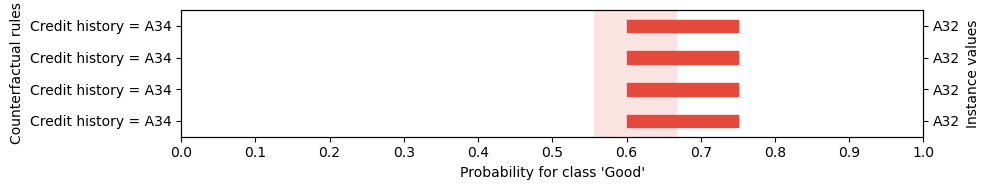

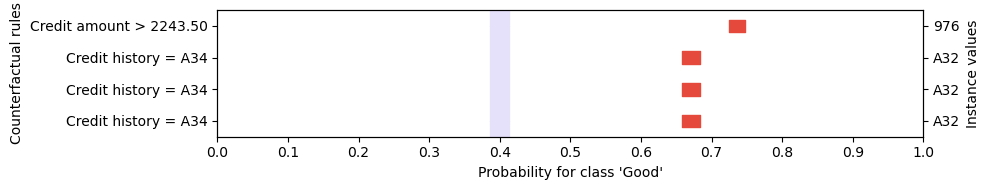

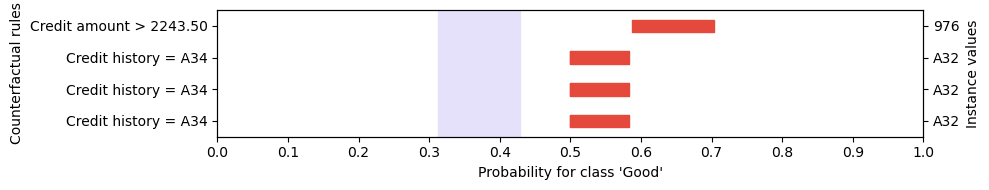

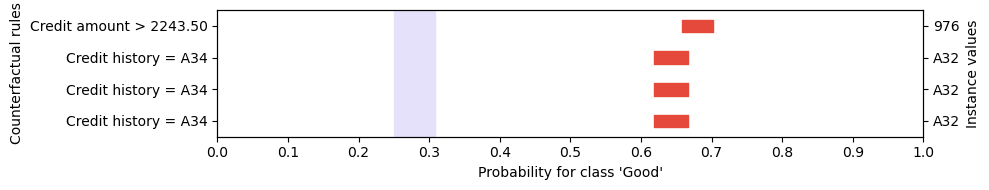

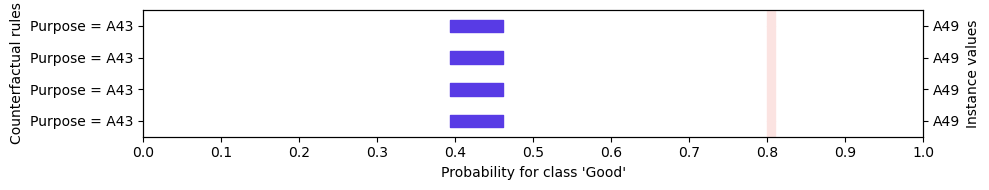

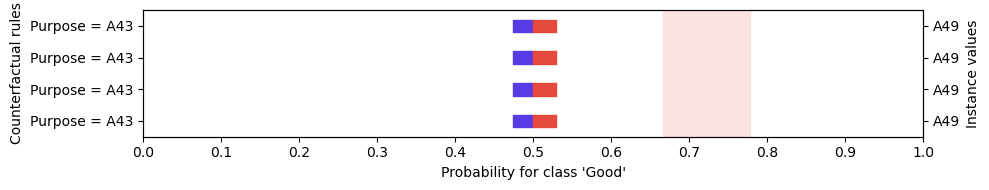

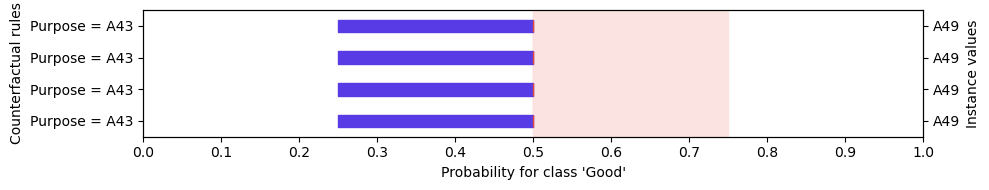

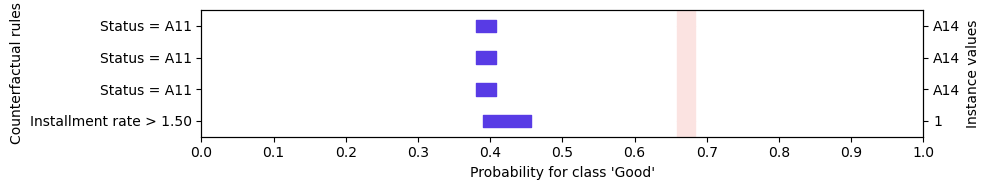

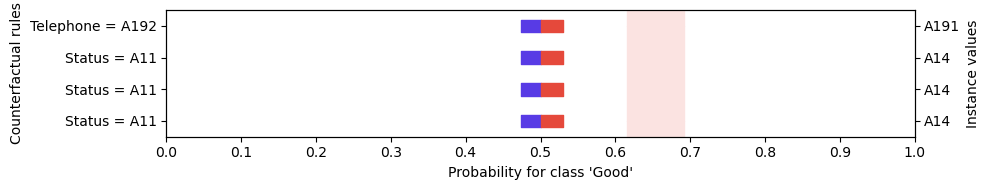

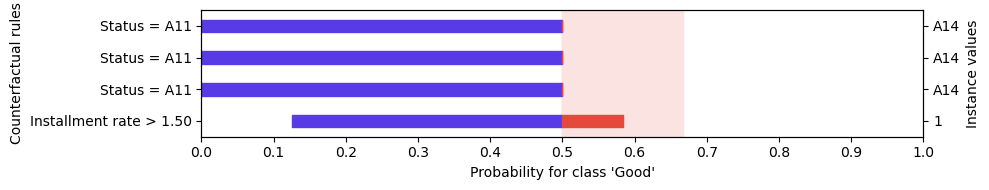

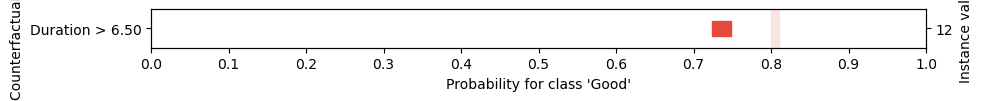

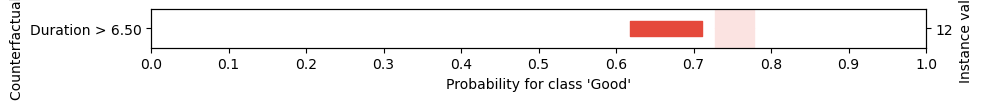

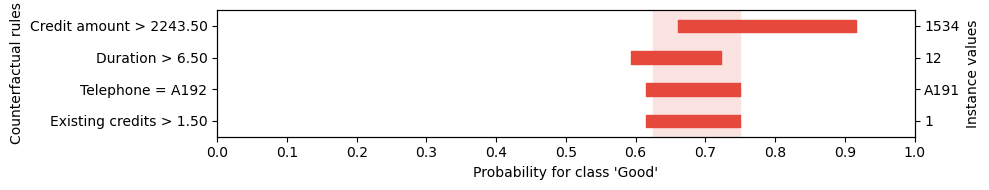

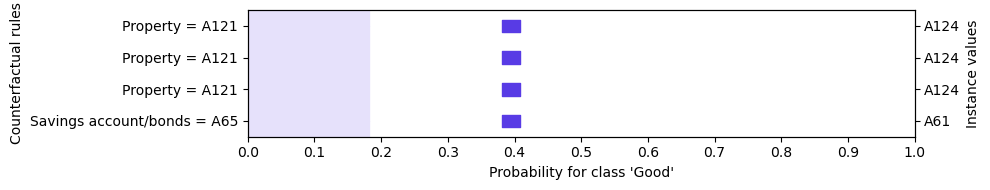

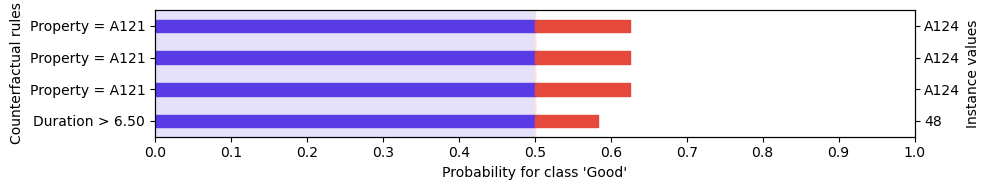

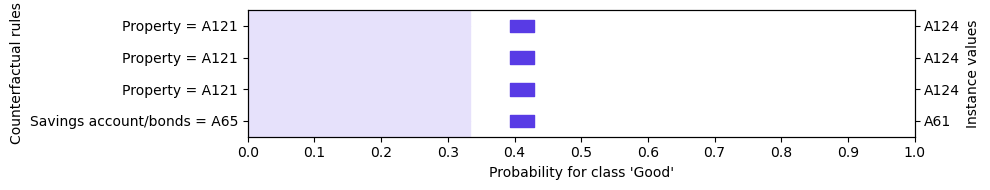

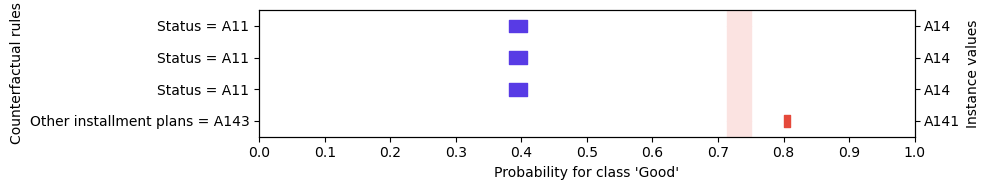

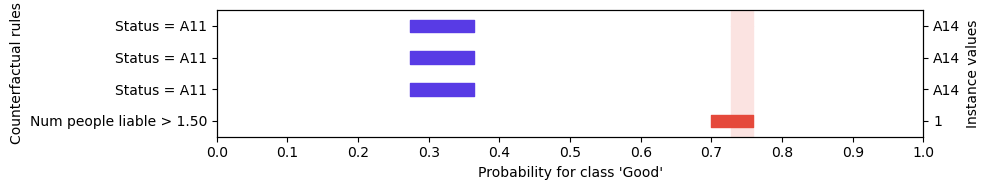

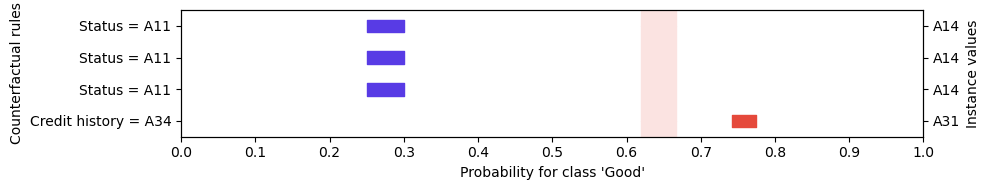

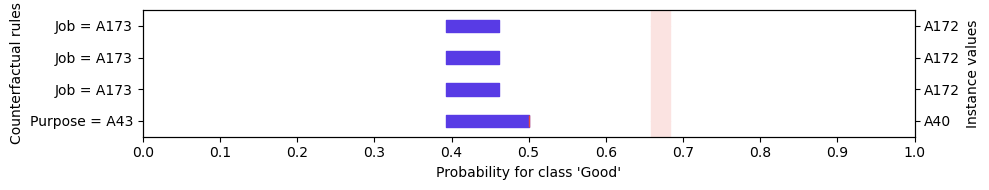

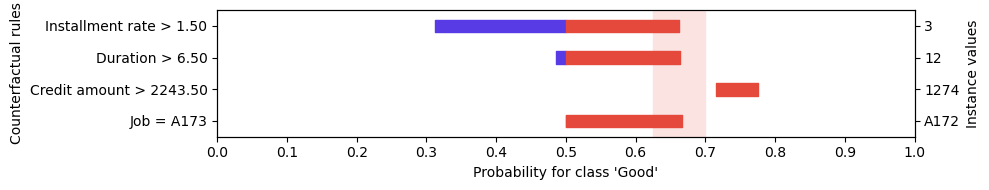

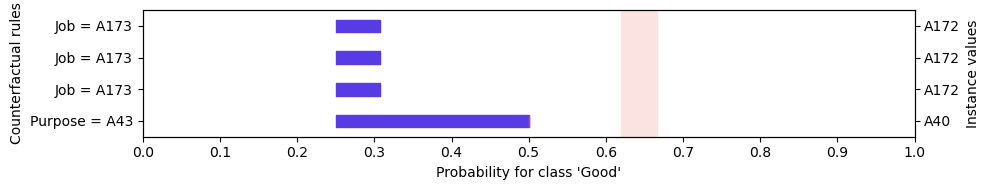

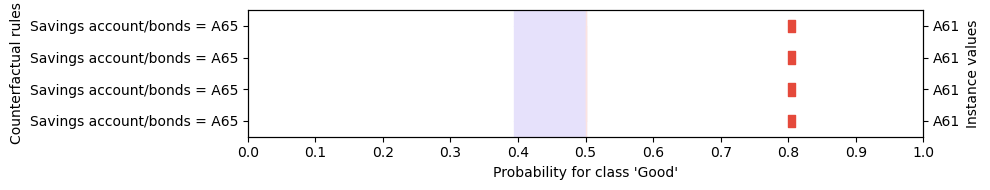

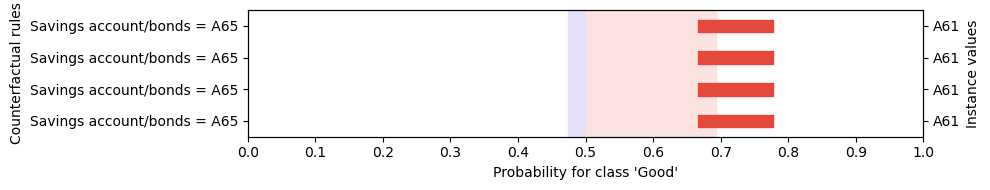

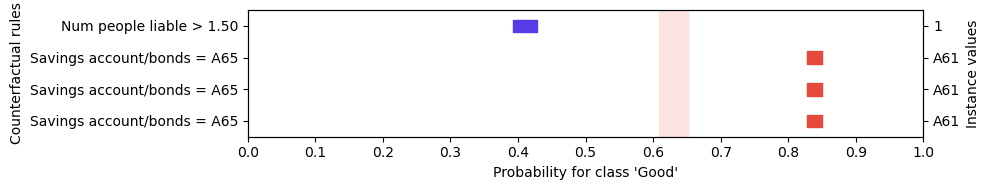

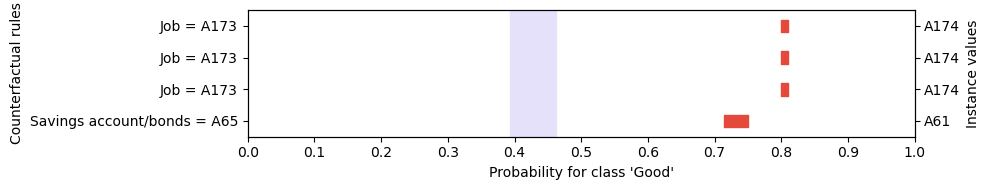

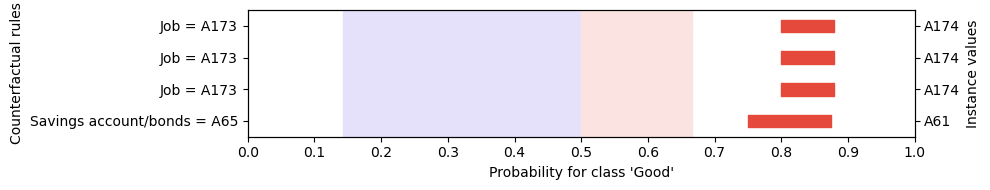

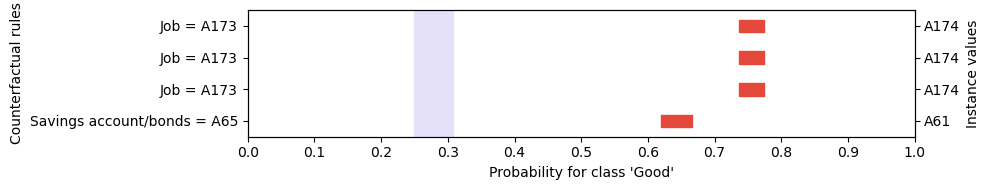

In [171]:
for i in range(len(testY)):     
    counterfactual_explanation.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_age.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_sex.plot_explanation(i, n_features_to_show=4)